# Table of Contents

1. <a href='#Notebook-order-to-get-to-this-point'>Notebook order to get to this point</a>
2. <a href='#Adding-Data'>Adding Data</a>
3. <a href='#Compute-Age/Sex-Stats-Using-Bootstrap'>Age & Sex</a>
4. <a href='#Compute-Race-Stats-Using-Bootstrap'>Race & Ethnicity</a>
5. <a href='#Compute-Time-Differential-ECG/Echo-Stats-Using-Bootstrap'>Time from ECG to Echo</a>
6. <a href='#Compute-Bundle-Branch-and-QRS-Stats-Using-Bootstrap'>Bundle Branch & QRS</a>
7. <a href='#Generate-Summary-Stats-for-Table-1-and-2'>Summary Stats for All Subgroups (Tables 1 & 2)</a>
8. <a href='#Now-we-run-the-vary_prevalance-scripts-from-ValveNet_v2-back-on-the-Dendrite-server'>Varying Prevalence (Table 3)</a>
9. <a href='#Test-Set-AUROC-and-AUPRC-Curves-(Fig-3A-and-3B)'>Overall AUROC & AUPRC (Figure 3A/3B)</a>
10. <a href='#Compute-a-Logistic-Regression-Model-using-Tabular-Data'>Logistic Regression on Tabular Data</a>
11. <a href='#NYP-Lawrence-Validation-with-and-without-Propensity-Score-Matching'>NYP Lawrence Validation</a>
12. <a href='#Model Calibration Curves'>Model Calibration Curves</a> 
13. <a href='#Determine PPV and NPV at Youden Index value per model'>Determining Performance per Model at Youden Index</a>


In [1]:
import pyodbc
import pandas as pd

from sqlalchemy import create_engine
from timeit import default_timer as timer

import numpy as np
import time

from datetime import date, timedelta   

from openpyxl import load_workbook
from itertools import islice

from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns

import re
import os

import statsmodels.api as sm

from scipy import stats

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from tqdm import tqdm, tqdm_notebook

import math

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def cm(y_total,yhat_total,threshold = 0.5):
    print(threshold)
    cm = confusion_matrix(y_total,yhat_total>threshold)
    tn, fp, fn, tp = confusion_matrix(y_total,yhat_total>threshold).ravel()
    specificity = ( tn / (tn+fp) )
    sensitivity= ( tp / (tp+fn) )
    print('Positive Predictive Value',round(tp/(tp+fp),2),'Negative Predictive Value', round(tn/(tn+fn),2), ' Specificty ', specificity, 'Sensitivity ', sensitivity)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Event','Adverse Event'])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.grid(visible=None)
    plt.show()
    
def point(y_total,yhat_total,t):
    specificity = []
    sensitivity = []
    for i in t:
        tn, fp, fn, tp = confusion_matrix(y_total, yhat_total>i).ravel()
        specificity.append( tn / (tn+fp) )
        sensitivity.append( tp / (tp+fn) )
    return t[(np.array(specificity) + np.array(sensitivity) - 1).argmax()]

def bootstrap(df, y_true_col, y_score_col, n_samples = 100):
    print(df.name, '\n')
    
    y_total, yhat_total = df[y_true_col].values, df[y_score_col].values
    n = len(df)
    print(n)
    fpr_boot = []
    tpr_boot = []
    aucs = []
    fpr, tpr, t = roc_curve(y_total, yhat_total)
    thresh = point(y_total, yhat_total, t)
    
    # bootstrap for confidence interval
    for i in tqdm(range(0,n_samples)):
        choices = np.random.choice(range(0,len(yhat_total)),int(len(yhat_total)/2))
        fpr,tpr, _ = roc_curve(y_total[choices],yhat_total[choices])
        fpr_boot.append(fpr)
        tpr_boot.append(tpr)
        aucs.append(auc(fpr,tpr))
        
    low,high = np.nanmean(aucs)-np.nanstd(aucs)*1.96,np.nanmean(aucs)+np.nanstd(aucs)*1.96
    lower_point = round(np.percentile(aucs,2.5),2)
    higher_point = round(np.percentile(aucs,97.5),2)
    mean_point = round(np.nanmean(aucs), 2)
    
    x = plt.hist(aucs, bins = 50, label = 'mean: '+ str(mean_point))

    plt.plot([np.percentile(aucs,2.5),np.percentile(aucs,2.5)],[0,max(x[0])],label = 'lower interval: ' + str(lower_point))
    plt.plot([np.percentile(aucs,97.5),np.percentile(aucs,97.5)],[0,max(x[0])],label = 'higher interval: ' + str(higher_point))
    plt.title("AUC Histogram")
    plt.xlabel("AUC")
    plt.legend()
    plt.show()

    plt.figure()
    lw = 2
    for i in range(0,1000):
        plt.plot(fpr_boot[i],tpr_boot[i], color='lightblue',
                 lw=lw)
    fpr,tpr, _ = roc_curve(y_total,yhat_total)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_results_by_factor_by_target(df, factor, target):
    if factor == 'All':
        if target == 'AS':
             plot_results(df, factor_name = factor, y_true_col = 'y_AS', y_score_col = 'y_pred_AS_proba_sigmoid')
        if target == 'AI':
             plot_results(df, factor_name = factor, y_true_col = 'y_AI', y_score_col = 'y_pred_AI_proba_sigmoid')       
        if target == 'MR':
             plot_results(df, factor_name = factor, y_true_col = 'y_MR', y_score_col = 'y_pred_MR_proba_sigmoid')
        if target == 'AS_AI_MR':
             plot_results(df, factor_name = factor, y_true_col = 'y_AS_AI_MR', y_score_col = 'y_pred_AS_AI_MR_proba_sigmoid')
             
    else:
        if target == 'AS':
             df.groupby([factor], dropna = False).apply(lambda x: plot_results(x, factor_name = factor, y_true_col = 'y_AS', y_score_col = 'y_pred_AS_proba_sigmoid'))
        if target == 'AI':
             df.groupby([factor], dropna = False).apply(lambda x: plot_results(x, factor_name = factor, y_true_col = 'y_AI', y_score_col = 'y_pred_AI_proba_sigmoid'))        
        if target == 'MR':
             df.groupby([factor], dropna = False).apply(lambda x: plot_results(x, factor_name = factor, y_true_col = 'y_MR', y_score_col = 'y_pred_MR_proba_sigmoid'))
        if target == 'AS_AI_MR':
             df.groupby([factor], dropna = False).apply(lambda x: plot_results(x, factor_name = factor, y_true_col = 'y_AS_AI_MR', y_score_col = 'y_pred_AS_AI_MR_proba_sigmoid'))   
                
def plot_results(df, factor_name, y_true_col, y_score_col):
    if not os.path.isdir('figures'):
        os.mkdir('figures')
    
    print(df.name, '\n')
    level_name = str(df.name).replace('/','_')
    y_true, y_scores = df[y_true_col], df[y_score_col]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    roc_auc = np.round(roc_auc_score(y_true, y_scores),2)
    print('AUROC is:', roc_auc)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)

    # plot_roc_curve(fpr, tpr)
    plt.figure()
    df['y_pred_AS_proba_sigmoid'].hist(bins=50)
    #plt.savefig(f'figures/{df.name.replace('/','_')}_{y_true_col}_hist.png')
    plt.savefig('figures/{}_{}_{}_hist.png'.format(factor_name,level_name,y_true_col))
    plt.close()
    
    plt.figure()
    sns.distplot(df.loc[df[y_true_col] ==  0][y_score_col], color="skyblue", label="Pos",bins=50)
    sns.distplot(df.loc[df[y_true_col] == 1][y_score_col], color="red", label="Neg",bins=50)
    y_pred_optimal = [1 if i > optimal_threshold else 0 for i in df[y_score_col]]
    plt.savefig('figures/{}_{}_{}_distplot.png'.format(factor_name,level_name,y_true_col))
    #plt.show()
    plt.close()
    
    # create heatmap
    cnf_matrix = confusion_matrix(y_true, np.round(y_scores))
    oddsratio, pvalue = stats.fisher_exact(cnf_matrix)
    print('Odds Ratio is:', round(oddsratio,1), 'P-Value is:', round(pvalue,3))
    
    mtx = sm.stats.Table2x2(cnf_matrix)
   
    display(mtx.summary())
    #plt.savefig('figures/{}_{}_summary.png'.format(_name,y_true_col))
    
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.set_ylim(ymin=0,ymax=2)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'Confusion matrix with threshold 0.5 [OR={np.round(oddsratio,1)},p={np.round(pvalue,3)}]', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig('figures/{}_{}_{}_confusion_matrix_0.5.png'.format(factor_name,level_name,y_true_col))
    plt.close()
    
    cnf_matrix = confusion_matrix(y_true, y_pred_optimal)
    oddsratio, pvalue = stats.fisher_exact(cnf_matrix)
    print('Odds Ratio is:', round(oddsratio,1), 'P-Value is:', round(pvalue,3))
    
    mtx = sm.stats.Table2x2(cnf_matrix)
    display(mtx.summary())
    
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.set_ylim(ymin=0,ymax=2)
    ax.xaxis.set_label_position("top")
    plt.tight_layout() #optimal threshold = (max(tpr-fpr))
    plt.title(f'Confusion matrix with optimal threshold {np.round(optimal_threshold,3)} [OR={np.round(oddsratio,1)},p={np.round(pvalue,3)}]', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig('figures/{}_{}_{}_confusion_matrix_optimal.png'.format(factor_name,level_name,y_true_col))
    plt.close()

def bootstrap_stats(df, y_true_col, y_score_col, n_samples = 100):
    print(df.name, '\n')
    y_total, yhat_total = df[y_true_col].values, df[y_score_col].values
    n = len(df)
    
    fpr_boot = []
    tpr_boot = []
    aucs = []
    odds_ratios = []
    
    fpr, tpr, t = roc_curve(y_total, yhat_total)
    roc_auc_actual = auc(fpr,tpr)  # from the complete data set
    roc_auc_actual = np.round(roc_auc_actual,2)
    cnf_matrix = confusion_matrix(y_total, np.round(yhat_total))
    odds_ratio_actual, pvalue = stats.fisher_exact(cnf_matrix)
    odds_ratio_actual = np.round(odds_ratio_actual,1)
     # set an arbitrary min size for bootstrapping
    if n < 200:
        return {'n': n, 'n_positives': sum(y_total), 'roc_auc_actual': roc_auc_actual, 'AU-ROC (95% CI)': None, 'odds_ratio_actual': odds_ratio_actual, 'OR (95% CI)': None}
    
    # bootstrap for confidence interval
    for i in tqdm(range(0,n_samples)):
        choices = np.random.choice(range(0,len(yhat_total)),int(len(yhat_total)/2))
        fpr,tpr, _ = roc_curve(y_total[choices],yhat_total[choices])
        
        cnf_matrix = confusion_matrix(y_total[choices],np.round(yhat_total[choices])) 
        odds_ratio_boot, _ = stats.fisher_exact(cnf_matrix)
        
        fpr_boot.append(fpr)
        tpr_boot.append(tpr)
        aucs.append(auc(fpr,tpr))
        odds_ratios.append(odds_ratio_boot)
        
    auc_low, auc_high = np.nanmean(aucs)-np.nanstd(aucs)*1.96,np.nanmean(aucs)+np.nanstd(aucs)*1.96
    auc_lower_point = round(np.percentile(aucs,2.5),2)
    auc_higher_point = round(np.percentile(aucs,97.5),2)
    auc_mean_point = round(np.nanmean(aucs), 2)
    print(auc_lower_point, auc_higher_point, auc_low, auc_high)
    
    odds_ratio_low, odds_ratio_high = np.nanmean(odds_ratios)-np.nanstd(odds_ratios)*1.96,np.nanmean(odds_ratios)+np.nanstd(odds_ratios)*1.96
    odds_ratio_lower_point = round(np.percentile(odds_ratios,2.5),1)
    odds_ratio_higher_point = round(np.percentile(odds_ratios,97.5),1)
    odds_ratio_mean_point = round(np.nanmean(odds_ratios), 1)
    
    # plt.figure()
    # lw = 2
    # for i in range(0,n_samples):
    #     plt.plot(fpr_boot[i],tpr_boot[i], color='lightblue',lw=lw)
    # fpr,tpr, _ = roc_curve(y_total,yhat_total)
    # plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    # plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curve')
    # plt.legend(loc="lower right")
    # plt.show()
    
    return {'n':n, 'n_positives': sum(y_total), 'roc_auc_actual':roc_auc_actual, 'AU-ROC (95% CI)': [auc_lower_point, auc_higher_point], 'odds_ratio_actual':odds_ratio_actual, 'OR (95% CI)': [odds_ratio_lower_point, odds_ratio_higher_point]}
    # return (n, roc_auc_actual, odds_ratio_actual, lower_point, mean_point, higher_point)

def get_odds_ratio(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    odds_ratio, pvalue = stats.fisher_exact(cnf_matrix)
    return odds_ratio 

# Version of bootstrap which returns the fpr, tpr rather than plotting 
def boot(df):
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr_boot = []
    tpr_boot = []
    aucs = []
    folder=None
    fpr,tpr, t = roc_curve( y_true,y_scores)
    thresh = point(y_true,y_scores,t)
    lw = 2
    
    # bootstrap for confidence interval
    for i in tqdm(range(0,1000)):
        choices = np.random.choice(range(0,len(y_scores)),int(len(y_scores)/2))
        fpr,tpr, _ = roc_curve(y_true[choices],y_scores[choices])
        fpr_boot.append(fpr)
        tpr_boot.append(tpr)
        aucs.append(auc(fpr,tpr))
        
    return fpr_boot, tpr_boot, aucs

def query_sql(query, server = 'drtprd02jup01',database = 'JupiterSCM'):
    start = timer()
    engine = create_engine("mssql+pyodbc://{}/{}?driver=SQL+Server".format(server,database),fast_executemany=True)
    conn = engine.connect()
    print('Running query...')
    result = pd.read_sql(con=conn, sql = query)
    conn.close()
    end = timer()
    print('Query took %s minutes' % round((end - start)/60,2))
    return result

def generate_age_multisite(df,study_date,dob):
    df[study_date] = pd.to_datetime(df[study_date],errors='coerce')
    df[dob] = pd.to_datetime(df[dob],errors='coerce')
    DateofBirth_D = []
    df['PatientAge_Years'] = (df[study_date] - df[dob]).dt.days//365
    print(f'Number of rows where age not calculated:{np.sum(df.PatientAge_Years.isnull())}')
    return df

def balance_binary(df, label, desired_prevalence):
    y = df[label]
    X = df
    binary_mask = np.bitwise_or(y == 0, y == 1)
    binary_y = y[binary_mask]
    binary_X = X[binary_mask]
    #this is the ratio of minority:majority class, so if you want 30% prevalence of positive label sampling_strategy = 0.3/0.7
    rus = RandomUnderSampler(sampling_strategy=(desired_prevalence/(1-desired_prevalence))) 
    X_res, y_res = rus.fit_resample(binary_X, binary_y)
    return X_res

def imbalance_binary(df, label, desired_prevalence, minority_class=1, majority_class=0):
    majority_count = int(len(df[df[label]==majority_class]))
    X_resampled, y_resampled = make_imbalance(
            df,
            df[label],
            sampling_strategy={majority_class:int(majority_count*(1-desired_prevalence)), minority_class:int(len(df)*desired_prevalence)})
    return X_resampled

def adjust_prevalence(df, label, desired_prevalence, minority_class=1):
    wanted_count = len(df)*desired_prevalence
    actual_count = Counter(df[label])[minority_class]
    ratio = wanted_count/actual_count
    if ratio >= 1:
        print('using RandomUnderSampler')
        new_df = balance_binary(df, label, desired_prevalence)
    else:
        print('using make_imbalance')
        new_df = imbalance_binary(df, label, desired_prevalence,minority_class)
    return new_df


# Notebook order to get to this point
1. Generate an updated test dataset that removes bioprosthetic ECG-echo pairings and generates 1:1 pairing between ecg and echo, only including complete (all 3 labels present) echos and ECGs done 0 to 365 days prior to echo in question. One pair per patient, most recent period where pair is valid, with largest time difference between ECG and echo as tiebreaker (b/t 0 to 365 days)  
    `/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Multivalvular_Label_Generation_No_Bioprosthesis_03_01_2022.ipynb`
    
***

2. Take that new list of ECG-echo pairs and run it on Dendrite to find the ECGs and preprocess the waveform arrays. Same for the tabular data. Then sanity check including looking at waveform/tabular output and going back into medical record to verify the label is correct, ecg is correct, and tabular data is correct. 
    `/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/ValveNet_JACC_Revision_Dataset_Generation_03_02_2022.ipynb`
    
***

3. Run the ValveNet_v2 engine on Dendrite (10.144.220.25). Running the CADnet branch of ValveNet_v2 files:
- eval_AI_no_prosthetics.py
- eval_AS_no_prosthetics.py
- eval_MR_no_prosthetics.py
- eval_AS_AI_MR_no_prosthetics.py
to generate the y,y_pred output for all 4 labels 

    `as_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv')`
`ai_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv)`
`mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv')`
`as_ai_mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv')`

***

4. And now we're ready to run the post-hoc analyses in this notebook

In [3]:
user = 'pae2'
box_path_prefix = f'/Users/{user}'

# original_test_27k = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/27k_test_metadata_no_prev_adjustment.csv'))
original_test_27k = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/JACC_REVISIONS_27k_test_metadata_no_prev_adjustment_new_ref.csv' ))
original_test_27k['AcquisitionDateTime_DT'] = pd.to_datetime(original_test_27k['AcquisitionDateTime_DT'])
print(original_test_27k.shape)

columns_needed = [
    'filename',
    'AcquisitionDateTime_DT',
    'TestID',
    'PatientID',
    'DateofBirth_D',
    'Gender',
    'Race',
    'aortic_stenosis_label_four_grade',
    'aortic_insufficiency_label_four_grade',
    'mitral_regurgitation_label_four_grade',
    'aortic_stenosis_label_binary',
    'mitral_regurgitation_label_binary',
    'aortic_insufficiency_label_binary',
    'aortic_stenosis_label_binary_backfilled',
    'aortic_insufficiency_label_binary_backfilled',
    'mitral_regurgitation_label_binary_backfilled',
    'AS_AI_MR_label_binary',
    'AS_AI_MR_label_binary_backfilled',              
    'QRSDuration',
    'RIGHT BUNDLE BRANCH BLOCK',
    'LEFT BUNDLE BRANCH BLOCK',
    'days_since_echo'
]

test_27k = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISION_test_df_newest_ecg_per_pt_tabular_metadata.csv'))
#print(test_27k.columns.tolist())



(26606, 161)


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,53,57,58,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Adding Data

# New file missing LBBB and RBBB so we need to add those 

In [3]:

tabular_labels = pd.read_csv('/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/Muse_Tabular_Labels_Master_04_24_2021.csv')
selection = ['TestID','LEFT BUNDLE BRANCH BLOCK', 'RIGHT BUNDLE BRANCH BLOCK']
test_27k = test_27k.merge(tabular_labels[selection], how='left',on='TestID', validate='1:1')
test_27k = test_27k[columns_needed]
test_27k['AcquisitionDateTime_DT'] = pd.to_datetime(test_27k['AcquisitionDateTime_DT'])

print(test_27k.shape)
# test_27k.groupby(['Ventricular_Pacing_Present','Poor_Data_Quality_Present']).size()

# # We might need to reindex these rows based on the original DF 
# test_27k = original_test_27k[['filename']].merge(test_27k, on = 'filename', suffixes = ('','_new'), how = 'inner', validate = '1:1')
# test_27k

(21048, 22)


# Backfill four_grade columns

In [4]:
test_27k[['aortic_stenosis_label_four_grade',
 'aortic_insufficiency_label_four_grade',
 'mitral_regurgitation_label_four_grade']].apply(pd.Series.value_counts)

aortic_stenosis_label_four_grade  aortic_insufficiency_label_four_grade  \
0.0                             15424                                  17088   
1.0                              1166                                   2348   
2.0                               284                                    166   
3.0                               623                                     30   

     mitral_regurgitation_label_four_grade  
0.0                                  13770  
1.0                                   4902  
2.0                                    601  
3.0                                    141

In [5]:
#Backfill the four_grade columns
fours = ['aortic_stenosis_label_four_grade',
 'aortic_insufficiency_label_four_grade',
 'mitral_regurgitation_label_four_grade']
for column in fours:
    test_27k[column] = test_27k[column].fillna(0)

In [6]:
test_27k[['aortic_stenosis_label_four_grade',
 'aortic_insufficiency_label_four_grade',
 'mitral_regurgitation_label_four_grade']].apply(pd.Series.value_counts)

aortic_stenosis_label_four_grade  aortic_insufficiency_label_four_grade  \
0.0                             18975                                  18504   
1.0                              1166                                   2348   
2.0                               284                                    166   
3.0                               623                                     30   

     mitral_regurgitation_label_four_grade  
0.0                                  15404  
1.0                                   4902  
2.0                                    601  
3.0                                    141

# Add PatientAge_Years

In [7]:
test_27k = generate_age_multisite(test_27k,'AcquisitionDateTime_DT','DateofBirth_D')

Number of rows where age not calculated:36


# Old test set counts vs new test set

In [8]:
list(filter(lambda x: 'four' in x, test_27k.columns))

['aortic_stenosis_label_four_grade',
 'aortic_insufficiency_label_four_grade',
 'mitral_regurgitation_label_four_grade']

In [9]:
original_test_27k[['aortic_stenosis_label_binary_backfilled', 'mitral_regurgitation_label_binary_backfilled',
       'aortic_insufficiency_label_binary_backfilled']].apply(pd.Series.value_counts)

aortic_stenosis_label_binary_backfilled  \
0                                    25460   
1                                     1146   

   mitral_regurgitation_label_binary_backfilled  \
0                                         25449   
1                                          1157   

   aortic_insufficiency_label_binary_backfilled  
0                                         26271  
1                                           335

In [10]:
test_27k[['aortic_stenosis_label_binary_backfilled', 'mitral_regurgitation_label_binary_backfilled',
       'aortic_insufficiency_label_binary_backfilled']].apply(pd.Series.value_counts)

aortic_stenosis_label_binary_backfilled  \
0.0                                    20141   
1.0                                      907   

     mitral_regurgitation_label_binary_backfilled  \
0.0                                         20306   
1.0                                           742   

     aortic_insufficiency_label_binary_backfilled  
0.0                                         20852  
1.0                                           196

In [11]:
test_27k.to_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_tabular_metadata_additional_backfill.csv'),index=False)

In [12]:
# test_27k.to_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/27k_test_metadata_no_prev_adjustment_newest_ecg_prosthetics_removed_metadata_reindexed.csv'))

# Append model scores to the data

In [13]:
# Append model scores to the data

# Original
as_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/Eval_Aortic_Stenosis_2022-01-18--04:38:05/y_y_pred_roc_0.8626.csv')
ai_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/Eval_Aortic_Insufficiency_2022-01-18--04:38:37/y_y_pred_roc_0.7661.csv')
mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/Eval_Mitral_Regurgitation_2022-01-18--04:39:09/y_y_pred_roc_0.8237.csv')
as_ai_mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/Eval_AS_AI_MR_Combination_2022-01-18--04:35:19/y_y_pred_roc_0.8281.csv')

as_pred = pd.read_csv(as_path, names = ['y_AS','y_pred_AS_proba'], dtype = {'y_AS':np.int64})
ai_pred = pd.read_csv(ai_path, names = ['y_AI','y_pred_AI_proba'], dtype = {'y_AI':np.int64})
mr_pred = pd.read_csv(mr_path, names = ['y_MR','y_pred_MR_proba'], dtype = {'y_MR':np.int64})
as_ai_mr_pred = pd.read_csv(as_ai_mr_path, names = ['y_AS_AI_MR','y_pred_AS_AI_MR_proba'], dtype = {'y_AS_AI_M':np.int64})

original_pred = pd.concat([as_pred, ai_pred, mr_pred, as_ai_mr_pred], axis = 1)
original_pred['y_pred_AS_proba_sigmoid'] = original_pred['y_pred_AS_proba'].map(sigmoid)
original_pred['y_pred_AI_proba_sigmoid'] = original_pred['y_pred_AI_proba'].map(sigmoid)
original_pred['y_pred_MR_proba_sigmoid'] = original_pred['y_pred_MR_proba'].map(sigmoid)
original_pred['y_pred_AS_AI_MR_proba_sigmoid'] = original_pred['y_pred_AS_AI_MR_proba'].map(sigmoid)

# Bioprosthesis removed
as_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv')
ai_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv')
mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv')
as_ai_mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv')

as_pred = pd.read_csv(as_path, names = ['y_AS','y_pred_AS_proba'], dtype = {'y_AS':np.int64})
ai_pred = pd.read_csv(ai_path, names = ['y_AI','y_pred_AI_proba'], dtype = {'y_AI':np.int64})
mr_pred = pd.read_csv(mr_path, names = ['y_MR','y_pred_MR_proba'], dtype = {'y_MR':np.int64})
as_ai_mr_pred = pd.read_csv(as_ai_mr_path, names = ['y_AS_AI_MR','y_pred_AS_AI_MR_proba'], dtype = {'y_AS_AI_M':np.int64})

pred = pd.concat([as_pred, ai_pred, mr_pred, as_ai_mr_pred], axis = 1)
pred['y_pred_AS_proba_sigmoid'] = pred['y_pred_AS_proba'].map(sigmoid)
pred['y_pred_AI_proba_sigmoid'] = pred['y_pred_AI_proba'].map(sigmoid)
pred['y_pred_MR_proba_sigmoid'] = pred['y_pred_MR_proba'].map(sigmoid)
pred['y_pred_AS_AI_MR_proba_sigmoid'] = pred['y_pred_AS_AI_MR_proba'].map(sigmoid)

test_pred = pd.concat([test_27k, pred], axis = 1)

lstFiles = [as_path,ai_path,mr_path,as_ai_mr_path]
study_name = [x.partition('Eval_')[2].partition('_2022')[0] for x in lstFiles]

In [14]:
original_pred[['y_AS','y_AI','y_MR','y_AS_AI_MR']].apply(pd.Series.value_counts)

y_AS   y_AI   y_MR  y_AS_AI_MR
0.0  25460  26271  25449       24307
1.0   1146    335   1157        2299

In [15]:
pred[['y_AS','y_AI','y_MR','y_AS_AI_MR']].apply(pd.Series.value_counts)

y_AS   y_AI   y_MR  y_AS_AI_MR
0  20141  20852  20306       19404
1    907    196    742        1644

# Generate Model Output Summary Table 

In [16]:
as_summary = test_pred.groupby(['aortic_stenosis_label_four_grade'], dropna = False)['y_pred_AS_proba_sigmoid'].describe(percentiles=[0.025, 0.975])
mr_summary = test_pred.groupby(['mitral_regurgitation_label_four_grade'], dropna = False)['y_pred_MR_proba_sigmoid'].describe(percentiles=[0.025, 0.975])
ai_summary = test_pred.groupby(['aortic_insufficiency_label_four_grade'], dropna = False)['y_pred_AI_proba_sigmoid'].describe(percentiles=[0.025, 0.975])

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))

summary_stats = pd.concat([as_summary,mr_summary,ai_summary], axis = 1)
summary_stats = summary_stats.rename(index = {0:'None/trace*',1:'Mild',2:'Moderate',3:'Severe'})

summary_stats.to_csv('summary_stats.csv')
#output_cols = ['y_pred_AS_proba', 'y_pred_AI_proba', 'y_pred_MR_proba', 'y_pred_AS_AI_MR_proba']

In [17]:
summary_stats

Aortic Stenosis                                                    \
                      count      mean       std       min      2.5%       50%   
None/trace*         18975.0  0.271788  0.219771  0.001363  0.012322  0.217372   
Mild                 1166.0  0.536695  0.218282  0.017030  0.115173  0.564480   
Moderate              284.0  0.590465  0.219712  0.044428  0.118110  0.627991   
Severe                623.0  0.701876  0.179399  0.142367  0.271392  0.741752   

                                Mitral Regurgitation                      \
                97.5%       max                count      mean       std   
None/trace*  0.775906  0.971297              15404.0  0.304829  0.162789   
Mild         0.880108  0.976182               4902.0  0.436290  0.182823   
Moderate     0.900383  0.928993                601.0  0.564647  0.157370   
Severe       0.934518  0.966101                141.0  0.588982  0.148862   

                                                               \
                  min      2.5%       50%     97.5%       max   
None/trace*  0.026033  0.085917  0.262900  0.672151  0.853389   
Mild         0.047727  0.132331  0.433334  0.739360  0.850087   
Moderate     0.083580  0.192651  0.610530  0.768853  0.823377   
Severe       0.098538  0.217909  0.637259  0.768774  0.800409   

            Aortic Insufficiency                                          \
                           count      mean       std       min      2.5%   
None/trace*              18504.0  0.320664  0.134718  0.057341  0.159497   
Mild                      2348.0  0.410783  0.155863  0.131194  0.198045   
Moderate                   166.0  0.476017  0.165181  0.129977  0.207978   
Severe                      30.0  0.565792  0.157375  0.235375  0.254424   

                                           
                  50%     97.5%       max  
None/trace*  0.277066  0.660512  0.893703  
Mild         0.374805  0.736602  0.940560  
Moderate     0.489910  0.783583  0.869834  
Severe       0.590199  0.808102  0.858896

# Exploring binary label vs. y discrepancies

In [18]:
test_pred.groupby(['y_AS','y_AI','y_MR']).size()

y_AS  y_AI  y_MR
0     0     0       19404
            1         586
      1     0         124
            1          27
1     0     0         742
            1         120
      1     0          36
            1           9
dtype: int64

### These seem to be consistent (except for 1 case) 

In [19]:
test_pred.groupby(['aortic_stenosis_label_binary_backfilled','aortic_stenosis_label_four_grade']).size()

aortic_stenosis_label_binary_backfilled  aortic_stenosis_label_four_grade
0.0                                      0.0                                 18975
                                         1.0                                  1166
1.0                                      2.0                                   284
                                         3.0                                   623
dtype: int64

In [20]:
test_pred.groupby(['aortic_stenosis_label_binary_backfilled','y_AS']).size()

aortic_stenosis_label_binary_backfilled  y_AS
0.0                                      0       20141
1.0                                      1         907
dtype: int64

In [21]:
test_pred.groupby(['mitral_regurgitation_label_binary_backfilled','y_MR']).size()

mitral_regurgitation_label_binary_backfilled  y_MR
0.0                                           0       20306
1.0                                           1         742
dtype: int64

In [22]:
test_pred.groupby(['aortic_insufficiency_label_binary_backfilled','y_AI']).size()

aortic_insufficiency_label_binary_backfilled  y_AI
0.0                                           0       20852
1.0                                           1         196
dtype: int64

In [23]:
test_pred[['y_AS', 'y_pred_AS_proba', 'y_AI', 'y_pred_AI_proba', 'y_MR', 'y_pred_MR_proba', 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba']].apply([min, max])

y_AS  y_pred_AS_proba  y_AI  y_pred_AI_proba  y_MR  y_pred_MR_proba  \
min     0        -6.597054     0        -2.799697     0        -3.622027   
max     1         3.713206     1         2.761508     1         1.761434   

     y_AS_AI_MR  y_pred_AS_AI_MR_proba  
min           0              -4.252630  
max           1               3.549835

# Generate Summary Table for Race / Ethnicity 

In [ ]:
race_ethnicity = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/RACE_ETHNICITY/west_empi_race_ethnicity_simplified_version.csv'))
print(race_ethnicity.shape)
race_ethnicity = race_ethnicity[race_ethnicity['EMPI'].notnull()]
print(race_ethnicity.shape)
race_ethnicity['EMPI'] = race_ethnicity['EMPI'].astype(np.int64)
race_ethnicity.head()

In [ ]:
syngo = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/RACE_ETHNICITY/SYNGO study with race and ethnicity per patient aggregation and simplification.csv'))
syngo['PATIENT_ID'] = pd.to_numeric(syngo['PATIENT_ID'], errors = 'coerce')
print(syngo.shape)
syngo = syngo[syngo['PATIENT_ID'].notnull()]
print(syngo.shape)

syngo['PATIENT_ID'] = syngo['PATIENT_ID'].astype(np.int64)
syngo.head()

### Append Race/Ethnicity Data

In [26]:
# test.set_index(['PatientID']).join(syngo.set_index('PATIENT_ID'), how = 'inner') # 23835
# test_race_ethnicity = test.drop('Race', axis = 1).set_index(['PatientID']).join(race_ethnicity.set_index('EMPI'), rsuffix = '_df', how = 'inner') # more rows with this join 25054

test_race_ethnicity = pd.merge(left = test_pred.drop('Race', axis = 1), left_on = ['PatientID'], right = race_ethnicity, right_on = ['EMPI'], how = 'left') 
test_race_ethnicity.shape[0]

21048

In [27]:
test_race_ethnicity.groupby(['Race'], dropna = False).size()

Race
ASIAN                      485
BLACK/AFRICAN AMERICAN    2559
DECLINED                  1302
NATIVEAM                    26
OTHER                     7590
WHITE                     7807
NaN                       1279
dtype: int64

In [28]:
test_race_ethnicity.groupby(['Ethnicity'], dropna = False).size()

Ethnicity
NOT HISPANIC OR LATINO     5290
SPANISH/HISPANIC           4034
UNKNOWN                   10370
NaN                        1354
dtype: int64

In [29]:
anna_race = pd.read_csv(os.path.join(box_path_prefix,'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/NYP_Lawrence/propensity-score-matching-main/race_test_combined_anna upd.csv'))
anna_cols = ['filename','RACE']

In [30]:
test_race_ethnicity = test_race_ethnicity.merge(anna_race[anna_cols],how='left',on='filename')
test_race_ethnicity['Race'] = test_race_ethnicity['RACE']
test_race_ethnicity.drop(columns=['RACE'],inplace=True)
test_race_ethnicity.groupby(['Race'], dropna = False).size()

Race
ASIAN                      485
BLACK/AFRICAN AMERICAN    3381
DECLINED                  1203
NATIVEAM                    26
OTHER                     6347
WHITE                     8589
NaN                       1017
dtype: int64

# Compute Age/Sex Stats Using Bootstrap

In [31]:
female_index = test_race_ethnicity[test_race_ethnicity.Gender==1].index
male_index = test_race_ethnicity[test_race_ethnicity.Gender==0].index

age18to60 = test_race_ethnicity[(test_race_ethnicity['PatientAge_Years'] >=0) & (test_race_ethnicity['PatientAge_Years'] <=60)].index
age60to70 = test_race_ethnicity[(test_race_ethnicity['PatientAge_Years'] >=61) & (test_race_ethnicity['PatientAge_Years'] <=70)].index
age70to80 = test_race_ethnicity[(test_race_ethnicity['PatientAge_Years'] >=71) & (test_race_ethnicity['PatientAge_Years'] <=80)].index
age80plus = test_race_ethnicity[(test_race_ethnicity['PatientAge_Years'] >=81) & (test_race_ethnicity['PatientAge_Years'] <=130)].index

age18to65 = test_race_ethnicity[(test_race_ethnicity['PatientAge_Years'] >=0) & (test_race_ethnicity['PatientAge_Years'] <=65)].index
age65plus = test_race_ethnicity[(test_race_ethnicity['PatientAge_Years'] >=65) & (test_race_ethnicity['PatientAge_Years'] <=130)].index

def new_age_column(row):
    if row['PatientAge_Years'] >=0 and row['PatientAge_Years'] <=60:
        return '18-60'
    elif row['PatientAge_Years'] >=61 and row['PatientAge_Years'] <=70:
        return '60-70'
    elif row['PatientAge_Years'] >=71 and row['PatientAge_Years'] <=80:
        return '70-80'
    elif row['PatientAge_Years'] >=81 and row['PatientAge_Years'] <=120:
        return '80+'
    else:
        return None


In [32]:
test_race_ethnicity['Patient_Age_Group'] = test_race_ethnicity.apply(new_age_column,axis =1)

<AxesSubplot:>

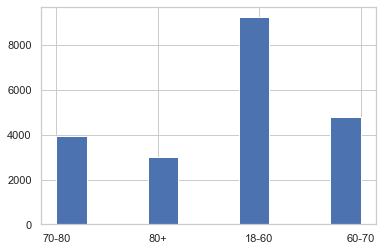

In [33]:
test_race_ethnicity['Patient_Age_Group'].hist()

In [34]:
factor_var = 'Patient_Age_Group'
target_var = 'AS_AI_MR'
plot_results_by_factor_by_target(test_race_ethnicity, factor_var, target_var)

18-60 

AUROC is: 0.81
Threshold value is: 0.27530762692370364


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 10.7 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 9.1 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

60-70 

AUROC is: 0.79
Threshold value is: 0.41694409320792375


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 6.1 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 7.5 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

70-80 

AUROC is: 0.72
Threshold value is: 0.5144382945813603


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 3.8 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 3.9 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

80+ 

AUROC is: 0.73
Threshold value is: 0.6513456467300284


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 5.0 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 4.3 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

nan 

AUROC is: 0.89
Threshold value is: 0.5335808680976182


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: inf P-Value is: 0.002


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 20.7 P-Value is: 0.008


<class 'statsmodels.iolib.table.SimpleTable'>

In [35]:
n_samples = 10 # bootstrap parameter

print('Aortic Stenosis')
as_summary = test_race_ethnicity.groupby(['Patient_Age_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples)))
print('\nMitral Regurgitation')
mr_summary = test_race_ethnicity.groupby(['Patient_Age_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples)))
print('\nAortic Insufficiency')
ai_summary = test_race_ethnicity.groupby(['Patient_Age_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples)))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = test_race_ethnicity.groupby(['Patient_Age_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)))           
print('\n\n\n')

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

age_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
age_summary_stats.to_csv('age_summary_stats.csv')

Aortic Stenosis
18-60 



100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


0.75 0.88 0.730097248666175 0.9176805793347693
60-70 



100%|██████████| 10/10 [00:00<00:00, 11.47it/s]


0.71 0.8 0.7019308909072053 0.8254304673223016
70-80 



100%|██████████| 10/10 [00:00<00:00, 19.52it/s]


0.72 0.79 0.718808566867564 0.7952340366099576
80+ 



100%|██████████| 10/10 [00:00<00:00, 31.05it/s]


0.72 0.78 0.7164895487694941 0.7762557265479183
nan 


Mitral Regurgitation
18-60 



100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


0.75 0.86 0.7508599733475103 0.8824598129228192
60-70 



100%|██████████| 10/10 [00:00<00:00, 13.38it/s]


0.82 0.87 0.8015219235996562 0.8839832015076687
70-80 



100%|██████████| 10/10 [00:00<00:00, 16.72it/s]


0.73 0.83 0.7180120179594174 0.8540374026348359
80+ 



100%|██████████| 10/10 [00:00<00:00, 30.31it/s]


0.67 0.76 0.6605119237164262 0.7638071307161832
nan 


Aortic Insufficiency
18-60 



100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


0.73 0.87 0.7240681444570903 0.9009310520437414
60-70 



100%|██████████| 10/10 [00:00<00:00, 11.40it/s]


0.63 0.83 0.6190394863561854 0.8638125653025401
70-80 



100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


0.63 0.78 0.6044662864009422 0.8049715703823834
80+ 



100%|██████████| 10/10 [00:00<00:00, 20.90it/s]
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


0.64 0.78 0.6076545211082022 0.8011775129506545
nan 


Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation
18-60 



100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


0.8 0.83 0.7918608815291726 0.8389628150475155
60-70 



100%|██████████| 10/10 [00:00<00:00, 12.03it/s]


0.76 0.82 0.7609023967654973 0.8255039023416939
70-80 



100%|██████████| 10/10 [00:00<00:00, 18.52it/s]


0.72 0.74 0.7122707064958184 0.7369380115398251
80+ 



100%|██████████| 10/10 [00:00<00:00, 24.51it/s]


0.71 0.76 0.7058830155136864 0.7610709448934017
nan 







# Plot Results by Age Group

['/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv', '/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv', '/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv', '/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv']
['Aortic_Stenosis', 'Aortic_Insufficiency', 'Mitral_Regurgitation', 'AS_AI_MR_Combination']

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval

100%|██████████| 1000/1000 [00:03<00:00, 257.97it/s]


AUROC is: 0.8331332744406912 0.8331332744406912
Threshold value is: 0.14236707472614496


100%|██████████| 1000/1000 [00:02<00:00, 379.22it/s]


AUROC is: 0.7845235557450437 0.7845235557450437
Threshold value is: 0.37757042779559474


100%|██████████| 1000/1000 [00:02<00:00, 462.21it/s]


AUROC is: 0.7588724569454022 0.7588724569454022
Threshold value is: 0.591104117144755


100%|██████████| 1000/1000 [00:02<00:00, 469.46it/s]


AUROC is: 0.7490658459186391 0.7490658459186391
Threshold value is: 0.7445367314698965
Aortic Stenosis [907 / 20,141] (AUROC=0.88)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv
All scores
AUROC is: 0.7687817837666431 0.7687817837666431
Threshold value is: 0.3979350694912722


100%|██████████| 1000/1000 [00:03<00:00, 268.13it/s]


AUROC is: 0.7945912098298676 0.7945912098298676
Threshold value is: 0.450291893659322


100%|██████████| 1000/1000 [00:02<00:00, 422.46it/s]


AUROC is: 0.7350061590401021 0.7350061590401021
Threshold value is: 0.4194478427674115


100%|██████████| 1000/1000 [00:02<00:00, 471.75it/s]


AUROC is: 0.6974560916096925 0.6974560916096925
Threshold value is: 0.3979350694912722


100%|██████████| 1000/1000 [00:01<00:00, 522.19it/s]


AUROC is: 0.714252367613712 0.714252367613712
Threshold value is: 0.48813259378734075
Aortic Regurgitation [196 / 20,852] (AUROC=0.769)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv
All scores
AUROC is: 0.828017318849102 0.828017318849102
Threshold value is: 0.45940651160283796


100%|██████████| 1000/1000 [00:03<00:00, 275.08it/s]


AUROC is: 0.8211550864849018 0.8211550864849018
Threshold value is: 0.38141647091004066


100%|██████████| 1000/1000 [00:02<00:00, 427.12it/s]


AUROC is: 0.8425296239982376 0.8425296239982376
Threshold value is: 0.44406463805623175


100%|██████████| 1000/1000 [00:02<00:00, 466.26it/s]


AUROC is: 0.7860715229787394 0.7860715229787394
Threshold value is: 0.48397561958293783


100%|██████████| 1000/1000 [00:01<00:00, 526.02it/s]


AUROC is: 0.7132101489244347 0.7132101489244347
Threshold value is: 0.5709031391543532
Mitral Regurgitation [742 / 20,306] (AUROC=0.828)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv
All scores
AUROC is: 0.8354910330275293 0.8354910330275293
Threshold value is: 0.45716718045293103


100%|██████████| 1000/1000 [00:03<00:00, 285.58it/s]


AUROC is: 0.8087341223412461 0.8087341223412461
Threshold value is: 0.27530762692370364


100%|██████████| 1000/1000 [00:02<00:00, 414.08it/s]


AUROC is: 0.7878099487855584 0.7878099487855584
Threshold value is: 0.41694409320792375


100%|██████████| 1000/1000 [00:02<00:00, 449.85it/s]


AUROC is: 0.7159081854485794 0.7159081854485794
Threshold value is: 0.5144382945813603


100%|██████████| 1000/1000 [00:01<00:00, 542.46it/s]


AUROC is: 0.7270918262876714 0.7270918262876714
Threshold value is: 0.6513456467300284
AS, AR, or MR Combination [1,644 / 19,404] (AUROC=0.835)


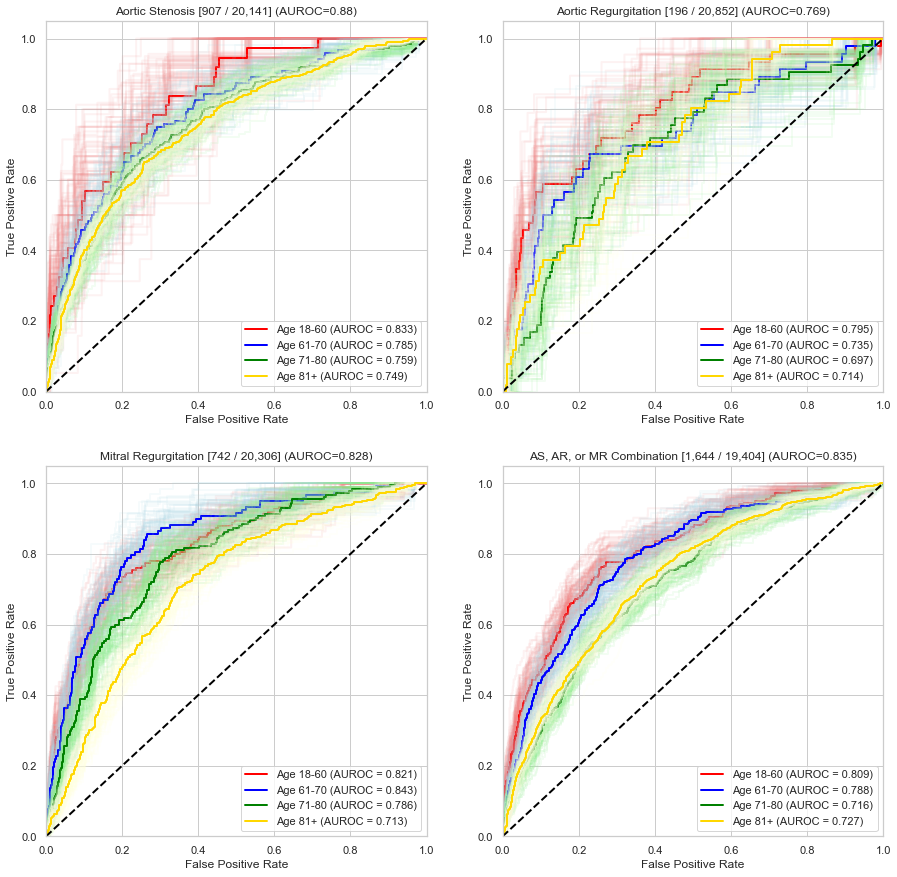

In [36]:
#generate counts of each label number of studies, only non 65 plus
n_AS, n_AI, n_MR, n_AS_AI_MR = 0,0,0,0
for study in study_name:
    if '65plus' not in study:
        if study=='AS':
            n_AS+=1
        if study.startswith('AI'):
            n_AI+=1
        if study.startswith('MR'):
            n_MR+=1
        if 'AS_AI_MR' in study:
            n_AS_AI_MR+=1
            
#generate color counts (must make separate for age 65 if we want the two studies that only differ from age to have same color)
c_AS, c_AI, c_MR, c_AS_AI_MR = 0,0,0,0
c65_AS, c65_AI, c65_MR, c65_AS_AI_MR = 0,0,0,0

print(lstFiles)
print(study_name)

columns = ['y','y_pred_proba']
#a = plt.figure(figsize=(15, 15), subplots = [1,2])  
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for file, ax in zip(lstFiles,ax.flatten()):
    #plt.figure(figsize=(15, 15))  
    print('\n',file)
    df = pd.read_csv(file, names=columns)
    df = pd.concat([test_race_ethnicity, df], axis = 1)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))

    # calculate scores
    print('All scores')
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    auroc_total = auroc
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    # test_pred[test_pred['QRSDuration'] <= 120]['QRSDuration'].value_counts()
    df_18_60 = df[df['Patient_Age_Group'] == '18-60'].reset_index().copy()
    df_60_70 = df[df['Patient_Age_Group'] == '60-70'].reset_index().copy()
    df_70_80 = df[df['Patient_Age_Group'] == '70-80'].reset_index().copy()
    df_80_plus = df[df['Patient_Age_Group'] == '80+'].reset_index().copy()

    
# df_18_60
    fpr_boot, tpr_boot, _ = boot(df_18_60)
    
    # plotting bootstrap
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightcoral',
                 lw=lw, alpha = .1)
        
    # calculate scores
    y_true,y_scores = df_18_60['y'],df_18_60['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    
    # plottring ROC
    ax.plot(fpr, tpr, color='red',
    lw=lw, label='Age 18-60 (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    
# df_60_70
    fpr_boot, tpr_boot, _ = boot(df_60_70)
    
    # plotting bootstrap
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightblue',
                 lw=lw, alpha = .1)
        
    # calculate scores
    y_true,y_scores = df_60_70['y'],df_60_70['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    # plotting ROC
    ax.plot(fpr, tpr, color='blue',
    lw=lw, label='Age 61-70 (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
# df_70_80
    fpr_boot, tpr_boot, _ = boot(df_70_80)
    
    # plotting bootstrap
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightgreen',
                 lw=lw, alpha = .1)
        
    # calculate scores
    y_true,y_scores = df_70_80['y'],df_70_80['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    # plotting ROC
    ax.plot(fpr, tpr, color='green',
    lw=lw, label='Age 71-80 (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
# df_80_plus
    fpr_boot, tpr_boot, _ = boot(df_80_plus)
    
    # plotting bootstrap
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightyellow',
                 lw=lw, alpha = .1)
        
    # calculate scores
    y_true,y_scores = df_80_plus['y'],df_80_plus['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    
    # plotting ROC
    ax.plot(fpr, tpr, color='gold',
    lw=lw, label='Age 81+ (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    
    

# Plotting the Rest    
    titlename = file.partition('Eval_')[2].partition('_2022')[0] + f' [{pos_count} / {neg_count}]' + f' (AUROC={auroc_total})'
    titlename = titlename.replace("AS_AI_MR", "AS, AR, or MR")
    titlename = titlename.replace("_", " ")
    titlename = titlename.replace("Aortic Insufficiency", "Aortic Regurgitation")
    print(titlename)

    ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(titlename)
    ax.legend(loc="lower right")
    

In [37]:
fig.savefig('figures/age_roc.png')

# Sex Summary Stats

In [40]:
def new_gender_column(row):
    if row['Gender'] ==1:
        return 'female' 
    elif row['Gender'] ==0:
        return 'male'
    else:
        return None

test_race_ethnicity['Gender_Group'] = test_race_ethnicity.apply(new_gender_column,axis=1)
    

In [44]:
n_samples = 1000 # bootstrap parameter

print('Aortic Stenosis')
as_summary = test_race_ethnicity.groupby(['Gender_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples)))
print('\nMitral Regurgitation')
mr_summary = test_race_ethnicity.groupby(['Gender_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples)))
print('\nAortic Insufficiency')
ai_summary = test_race_ethnicity.groupby(['Gender_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples)))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = test_race_ethnicity.groupby(['Gender_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)))           
print('\n\n\n')

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

gender_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
gender_summary_stats.to_csv('gender_summary_stats.csv')

Aortic Stenosis
female 



100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]


0.87 0.91 0.8671946663860116 0.9067624353464864
male 



100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


0.85 0.89 0.853465851083383 0.8948331734730581

Mitral Regurgitation
female 



100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]


0.79 0.85 0.7899195135781897 0.8483298850623756
male 



100%|██████████| 1000/1000 [02:41<00:00,  6.21it/s]


0.81 0.87 0.8143669285891035 0.8685378008365738

Aortic Insufficiency
female 



100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


0.66 0.82 0.6673672645499634 0.8269134134028334
male 



100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]


0.72 0.84 0.7188412947968956 0.8398562592208147

Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation
female 



100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


0.82 0.86 0.8210521960559966 0.8583817703873379
male 



100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]

0.81 0.85 0.8126983460363397 0.851611709201546






# Compute Race Stats Using Bootstrap

In [ ]:
n_samples = 1000 # bootstrap parameter

print('Aortic Stenosis')
as_summary = test_race_ethnicity.groupby(['Race'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples)))
print('\nMitral Regurgitation')
mr_summary = test_race_ethnicity.groupby(['Race'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples)))
print('\nAortic Insufficiency')
ai_summary = test_race_ethnicity.groupby(['Race'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples)))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = test_race_ethnicity.groupby(['Race'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)))           
print('\n\n\n')

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

race_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
race_summary_stats.to_csv('race_summary_stats.csv')

# Plot Results By Race

In [ ]:
factor_var = 'Race'
target_var = 'AS'
plot_results_by_factor_by_target(test_race_ethnicity, factor_var, target_var)


 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv
All scores
AUROC is: 0.8804872725564813 0.8804872725564813
Threshold value is: 0.4290496913006215
(8589, 41)
(3381, 41)


100%|██████████| 1000/1000 [00:04<00:00, 211.54it/s]


White
AUROC is: 0.8713834161233114 0.8713834161233114
Threshold value is: 0.48821429768368324


100%|██████████| 1000/1000 [00:02<00:00, 380.84it/s]


Black
AUROC is: 0.8679815838940801 0.8679815838940801
Threshold value is: 0.43497222371612443
Aortic Stenosis [907 / 11,970] (AUROC=0.88)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv
All scores
AUROC is: 0.7687817837666431 0.7687817837666431
Threshold value is: 0.3979350694912722
(8589, 41)
(3381, 41)


100%|██████████| 1000/1000 [00:03<00:00, 261.83it/s]


White
AUROC is: 0.7911882631674868 0.7911882631674868
Threshold value is: 0.4502594758980771


100%|██████████| 1000/1000 [00:02<00:00, 419.83it/s]


Black
AUROC is: 0.6937129556956887 0.6937129556956887
Threshold value is: 0.5060507886250929
Aortic Regurgitation [196 / 11,970] (AUROC=0.77)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv
All scores
AUROC is: 0.828017318849102 0.828017318849102
Threshold value is: 0.45940651160283796
(8589, 41)
(3381, 41)


100%|██████████| 1000/1000 [00:04<00:00, 207.37it/s]


White
AUROC is: 0.8286614061861972 0.8286614061861972
Threshold value is: 0.49102300861229714


100%|██████████| 1000/1000 [00:02<00:00, 399.57it/s]


Black
AUROC is: 0.7701759488148904 0.7701759488148904
Threshold value is: 0.433443442921303
Mitral Regurgitation [742 / 11,970] (AUROC=0.83)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv
All scores
AUROC is: 0.8354910330275293 0.8354910330275293
Threshold value is: 0.45716718045293103
(8589, 41)
(3381, 41)


100%|██████████| 1000/1000 [00:04<00:00, 223.86it/s]


White
AUROC is: 0.8373834239597975 0.8373834239597975
Threshold value is: 0.4820422523508854


100%|██████████| 1000/1000 [00:02<00:00, 402.33it/s]


Black
AUROC is: 0.7832236814606132 0.7832236814606132
Threshold value is: 0.45048856689025873
AS, AR, or MR Combination [1,644 / 11,970] (AUROC=0.84)


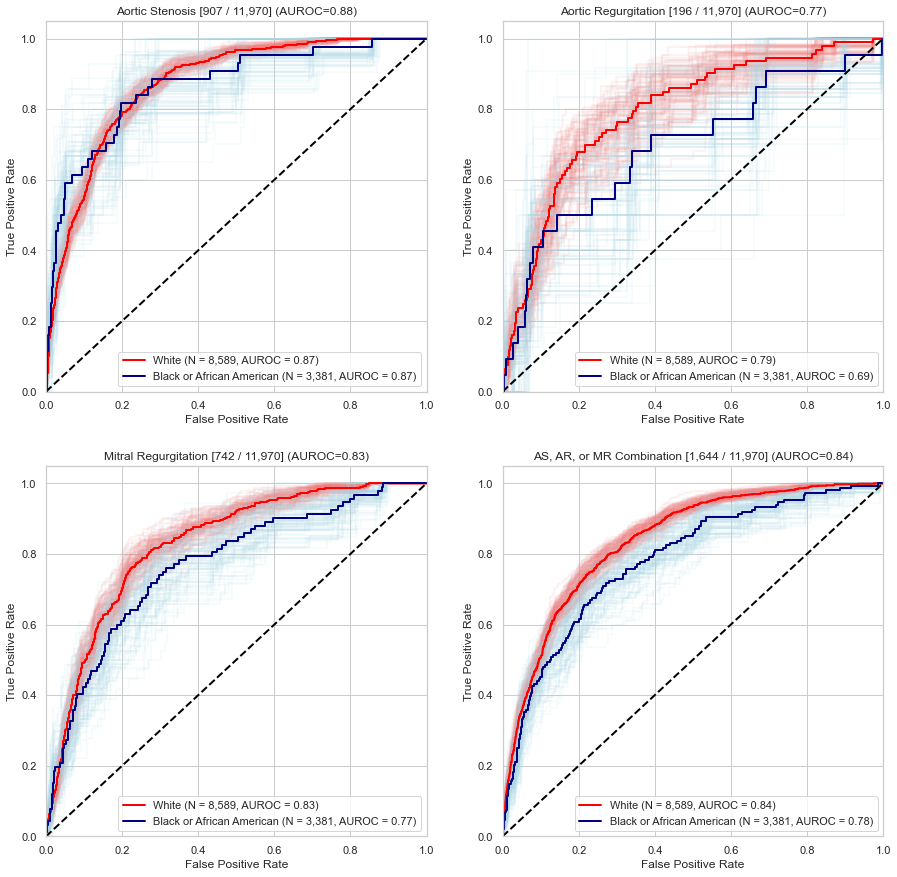

In [64]:
columns = ['y','y_pred_proba']
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for file, ax in zip(lstFiles,ax.flatten()):
    #plt.figure(figsize=(15, 15))  
    print('\n',file)
    df = pd.read_csv(file, names=columns)
    df = pd.concat([test_race_ethnicity, df], axis = 1)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))

    # calculate scores
    print('All scores')
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),2)
    auroc_total = auroc
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    df_white = df[df['Race'] == 'WHITE'].reset_index().copy()
    df_black = df[df['Race'] == 'BLACK/AFRICAN AMERICAN'].reset_index().copy()

    print(df_white.shape)
    print(df_black.shape)
    
    # Race white
    fpr_boot, tpr_boot, _ = boot(df_white)

    # plotting 
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightcoral',
                 lw=lw, alpha = .1)

    # calculate scores
    print('White')
    y_true,y_scores = df_white['y'],df_white['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),2)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    white_count = format(len(df_white),',d')
    print("Threshold value is:", optimal_threshold)

    # Race black
    fpr_boot, tpr_boot, _ = boot(df_black)

    # plotting 
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightblue',
                 lw=lw, alpha = .1)

    ax.plot(fpr, tpr, color='red',
         lw=lw, label=f'White (N = {white_count}, AUROC = %0.2f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

    # calculate scores
    print('Black')
    y_true,y_scores = df_black['y'],df_black['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),2)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    black_count = format(len(df_black),',d')
    print("Threshold value is:", optimal_threshold)

    total_pos_count = df_white['y'].sum() + df_black['y'].sum()
    total_count= len(df_white) + len(df_black)
    total_count = format(total_count,',d')
    titlename = file.partition('Eval_')[2].partition('_2022')[0] + f' [{pos_count} / {total_count}]' + f' (AUROC={auroc_total})'
    titlename = titlename.replace("AS_AI_MR", "AS, AR, or MR")
    titlename = titlename.replace("_", " ")
    titlename = titlename.replace("Aortic Insufficiency", "Aortic Regurgitation")
    ax.set_title(titlename)
    print(titlename)

    ax.plot(fpr, tpr, color='navy', lw=lw, label=f'Black or African American (N = {black_count}, AUROC = %0.2f)' % auc(fpr,tpr))
    ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

In [65]:
fig.savefig('figures/race_roc.png')

In [98]:
df_white.describe(percentiles=[0.025, 0.975]).apply(lambda s: s.apply('{0:.3f}'.format)).T

count            mean  \
index                                         8589.000        9909.026   
TestID                                        8589.000     2447798.348   
PatientID                                     8589.000  1049367271.334   
Gender                                        8589.000           0.476   
aortic_stenosis_label_four_grade              8589.000           0.243   
aortic_insufficiency_label_four_grade         8589.000           0.150   
mitral_regurgitation_label_four_grade         8589.000           0.325   
aortic_stenosis_label_binary                  6991.000           0.081   
mitral_regurgitation_label_binary             7821.000           0.041   
aortic_insufficiency_label_binary             7913.000           0.012   
aortic_stenosis_label_binary_backfilled       8589.000           0.066   
aortic_insufficiency_label_binary_backfilled  8589.000           0.011   
mitral_regurgitation_label_binary_backfilled  8589.000           0.037   
AS_AI_MR_label_binary                         8045.000           0.107   
AS_AI_MR_label_binary_backfilled              8589.000           0.100   
QRSDuration                                   8589.000          94.944   
RIGHT BUNDLE BRANCH BLOCK                     8564.000           0.069   
LEFT BUNDLE BRANCH BLOCK                      8564.000           0.027   
days_since_echo                               8589.000         -83.908   
PatientAge_Years                              8573.000          63.699   
y_AS                                          8589.000           0.066   
y_pred_AS_proba                               8589.000          -1.010   
y_AI                                          8589.000           0.011   
y_pred_AI_proba                               8589.000          -0.722   
y_MR                                          8589.000           0.037   
y_pred_MR_proba                               8589.000          -0.742   
y_AS_AI_MR                                    8589.000           0.100   
y_pred_AS_AI_MR_proba                         8589.000          -0.661   
y_pred_AS_proba_sigmoid                       8589.000           0.335   
y_pred_AI_proba_sigmoid                       8589.000           0.337   
y_pred_MR_proba_sigmoid                       8589.000           0.346   
y_pred_AS_AI_MR_proba_sigmoid                 8589.000           0.370   
EMPI                                          8426.000  1049877479.927   
y                                             8589.000           0.100   
y_pred_proba                                  8589.000          -0.661   

                                                       std             min  \
index                                             5802.364           0.000   
TestID                                          668207.679     1143854.000   
PatientID                                     80630740.047  1000000178.000   
Gender                                               0.499           0.000   
aortic_stenosis_label_four_grade                     0.711           0.000   
aortic_insufficiency_label_four_grade                0.394           0.000   
mitral_regurgitation_label_four_grade                0.568           0.000   
aortic_stenosis_label_binary                         0.273           0.000   
mitral_regurgitation_label_binary                    0.198           0.000   
aortic_insufficiency_label_binary                    0.108           0.000   
aortic_stenosis_label_binary_backfilled              0.248           0.000   
aortic_insufficiency_label_binary_backfilled         0.103           0.000   
mitral_regurgitation_label_binary_backfilled         0.189           0.000   
AS_AI_MR_label_binary                                0.309           0.000   
AS_AI_MR_label_binary_backfilled                     0.300           0.000   
QRSDuration                                         21.407           0.000   
RIGHT BUNDLE BRANCH BLOCK                            0.253

In [99]:
df_black.describe(percentiles=[0.025, 0.975]).apply(lambda s: s.apply('{0:.3f}'.format)).T

count            mean  \
index                                         3381.000       10168.915   
TestID                                        3381.000     2581400.382   
PatientID                                     3381.000  1059993983.839   
Gender                                        3381.000           0.548   
aortic_stenosis_label_four_grade              3381.000           0.064   
aortic_insufficiency_label_four_grade         3381.000           0.093   
mitral_regurgitation_label_four_grade         3381.000           0.282   
aortic_stenosis_label_binary                  2809.000           0.016   
mitral_regurgitation_label_binary             3154.000           0.029   
aortic_insufficiency_label_binary             3189.000           0.007   
aortic_stenosis_label_binary_backfilled       3381.000           0.013   
aortic_insufficiency_label_binary_backfilled  3381.000           0.007   
mitral_regurgitation_label_binary_backfilled  3381.000           0.027   
AS_AI_MR_label_binary                         3225.000           0.046   
AS_AI_MR_label_binary_backfilled              3381.000           0.044   
QRSDuration                                   3381.000          90.171   
RIGHT BUNDLE BRANCH BLOCK                     3370.000           0.047   
LEFT BUNDLE BRANCH BLOCK                      3370.000           0.015   
days_since_echo                               3381.000         -89.997   
PatientAge_Years                              3374.000          58.501   
y_AS                                          3381.000           0.013   
y_pred_AS_proba                               3381.000          -1.468   
y_AI                                          3381.000           0.007   
y_pred_AI_proba                               3381.000          -0.774   
y_MR                                          3381.000           0.027   
y_pred_MR_proba                               3381.000          -0.692   
y_AS_AI_MR                                    3381.000           0.044   
y_pred_AS_AI_MR_proba                         3381.000          -0.811   
y_pred_AS_proba_sigmoid                       3381.000           0.256   
y_pred_AI_proba_sigmoid                       3381.000           0.328   
y_pred_MR_proba_sigmoid                       3381.000           0.355   
y_pred_AS_AI_MR_proba_sigmoid                 3381.000           0.339   
EMPI                                          3282.000  1061308748.772   
y                                             3381.000           0.044   
y_pred_proba                                  3381.000          -0.811   

                                                       std             min  \
index                                             6025.273           5.000   
TestID                                          674721.852     1235844.000   
PatientID                                     94728634.304  1000003252.000   
Gender                                               0.498           0.000   
aortic_stenosis_label_four_grade                     0.332           0.000   
aortic_insufficiency_label_four_grade                0.314           0.000   
mitral_regurgitation_label_four_grade                0.521           0.000   
aortic_stenosis_label_binary                         0.124           0.000   
mitral_regurgitation_label_binary                    0.168           0.000   
aortic_insufficiency_label_binary                    0.083           0.000   
aortic_stenosis_label_binary_backfilled              0.113           0.000   
aortic_insufficiency_label_binary_backfilled         0.080           0.000   
mitral_regurgitation_label_binary_backfilled         0.163           0.000   
AS_AI_MR_label_binary                                0.209           0.000   
AS_AI_MR_label_binary_backfilled                     0.205           0.000   
QRSDuration                                         18.728           4.000   
RIGHT BUNDLE BRANCH BLOCK                            0.212

# Compute Ethnicity Stats Using Bootstrap

In [ ]:
n_samples = 1000 # bootstrap parameter
print('Aortic Stenosis')
as_summary = test_race_ethnicity.groupby(['Ethnicity'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples)))
print('\nMitral Regurgitation')
mr_summary = test_race_ethnicity.groupby(['Ethnicity'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples)))
print('\nAortic Insufficiency')
ai_summary = test_race_ethnicity.groupby(['Ethnicity'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples)))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = test_race_ethnicity.groupby(['Ethnicity'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)))           
print('\n\n\n')

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

ethnicity_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
ethnicity_summary_stats.to_csv('ethnicity_summary_stats.csv')

# Plot Results By Ethnicity

In [69]:
# This doesn't seem to work. Plotting comes out wierd.
# for y, y_true_col, y_score_col in [('Aortic Stenosis','y_AS','y_pred_AS_proba_sigmoid'), ('Aortic Insufficiency','y_AI','y_pred_AI_proba_sigmoid'), ('Mitral Regurgitation','y_MR','y_pred_MR_proba_sigmoid'), ('Combined','y_AS_AI_MR','y_pred_AS_AI_MR_proba_sigmoid')]:
#     print(y)
#     test_race_ethnicity.groupby(['Ethnicity'], dropna = False).apply(lambda x: plot_results(x, y_true_col, y_score_col))

# Still having trouble with groups overwriting one another 
factor_var = 'Ethnicity'
target_var = 'AS'
plot_results_by_factor_by_target(test_race_ethnicity, factor_var, target_var)

NOT HISPANIC OR LATINO 

AUROC is: 0.86
Threshold value is: 0.48230155998638263


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 14.5 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 15.1 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

SPANISH/HISPANIC 

AUROC is: 0.88
Threshold value is: 0.44052041757831195


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 15.1 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 15.8 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

UNKNOWN 

AUROC is: 0.89
Threshold value is: 0.4274447734495537


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 16.1 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 21.4 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

nan 

AUROC is: 0.86
Threshold value is: 0.5918834778185068


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 10.5 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 12.5 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>


 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv
All scores
AUROC is: 0.8804872725564813 0.8804872725564813
Threshold value is: 0.4290496913006215
(5290, 42)
(4034, 42)


100%|██████████| 1000/1000 [00:03<00:00, 325.89it/s]


Not Hispanic
AUROC is: 0.8639202926087781 0.8639202926087781
Threshold value is: 0.48230155998638263


100%|██████████| 1000/1000 [00:02<00:00, 348.32it/s]


Hispanic
AUROC is: 0.8819814293978019 0.8819814293978019
Threshold value is: 0.44052041757831195
Aortic Stenosis [907 / 20,141] (AUROC=0.88)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv
All scores
AUROC is: 0.7687817837666431 0.7687817837666431
Threshold value is: 0.3979350694912722
(5290, 42)
(4034, 42)


100%|██████████| 1000/1000 [00:03<00:00, 298.86it/s]


Not Hispanic
AUROC is: 0.721647272033575 0.721647272033575
Threshold value is: 0.47691565923631085


100%|██████████| 1000/1000 [00:02<00:00, 336.87it/s]


Hispanic
AUROC is: 0.6792457703732403 0.6792457703732403
Threshold value is: 0.3979350694912722
Aortic Regurgitation [196 / 20,852] (AUROC=0.769)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv
All scores
AUROC is: 0.828017318849102 0.828017318849102
Threshold value is: 0.45940651160283796
(5290, 42)
(4034, 42)


100%|██████████| 1000/1000 [00:03<00:00, 319.63it/s]


Not Hispanic
AUROC is: 0.8314383561643836 0.8314383561643836
Threshold value is: 0.4676501101949141


100%|██████████| 1000/1000 [00:02<00:00, 355.90it/s]


Hispanic
AUROC is: 0.8219206618456686 0.8219206618456686
Threshold value is: 0.5021834840032425
Mitral Regurgitation [742 / 20,306] (AUROC=0.828)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv
All scores
AUROC is: 0.8354910330275293 0.8354910330275293
Threshold value is: 0.45716718045293103
(5290, 42)
(4034, 42)


100%|██████████| 1000/1000 [00:03<00:00, 329.72it/s]


Not Hispanic
AUROC is: 0.8333336276154322 0.8333336276154322
Threshold value is: 0.5103109684980559


100%|██████████| 1000/1000 [00:02<00:00, 391.64it/s]


Hispanic
AUROC is: 0.8203316797819682 0.8203316797819682
Threshold value is: 0.4543221183650831
AS, AR, or MR Combination [1,644 / 19,404] (AUROC=0.835)


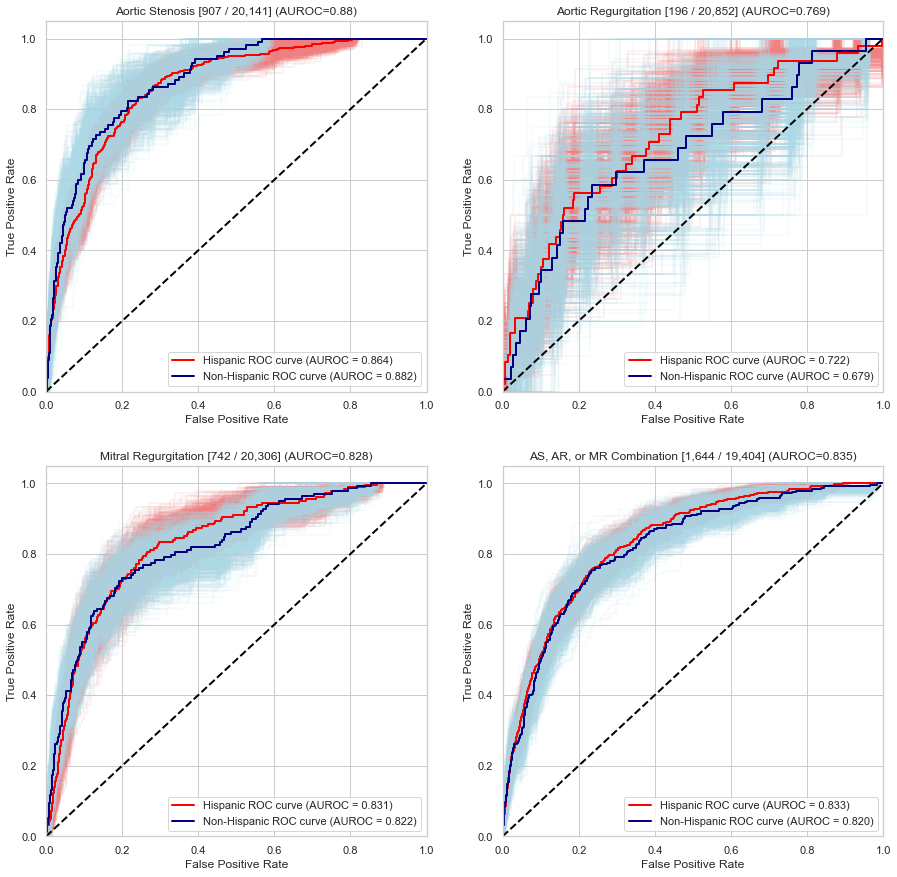

In [70]:
columns = ['y','y_pred_proba']
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for file, ax in zip(lstFiles,ax.flatten()):
    #plt.figure(figsize=(15, 15))  
    print('\n',file)
    df = pd.read_csv(file, names=columns)
    df = pd.concat([test_race_ethnicity, df], axis = 1)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))

    # calculate scores
    print('All scores')
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    auroc_total = auroc
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    df_not_hispanic = df[df['Ethnicity'] == 'NOT HISPANIC OR LATINO'].reset_index().copy()
    df_hispanic = df[df['Ethnicity'] == 'SPANISH/HISPANIC'].reset_index().copy()

    print(df_not_hispanic.shape)
    print(df_hispanic.shape)
    
    # Ethnicity not hispanic
    fpr_boot, tpr_boot, _ = boot(df_not_hispanic)
    
    # plotting 
    lw = 2
    for i in range(0,1000):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightcoral',
                 lw=lw, alpha = .1)
        
    # calculate scores
    print('Not Hispanic')
    y_true,y_scores = df_not_hispanic['y'],df_not_hispanic['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    # Ethnicity hispanic
    fpr_boot, tpr_boot, _ = boot(df_hispanic)
    
    # plotting 
    lw = 2
    for i in range(0,1000):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightblue',
                 lw=lw, alpha = .1)
    
    ax.plot(fpr, tpr, color='red',
         lw=lw, label='Hispanic ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    # calculate scores
    print('Hispanic')
    y_true,y_scores = df_hispanic['y'],df_hispanic['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    titlename = file.partition('Eval_')[2].partition('_2022')[0] + f' [{pos_count} / {neg_count}]' + f' (AUROC={auroc_total})'
    titlename = titlename.replace("AS_AI_MR", "AS, AR, or MR")
    titlename = titlename.replace("_", " ")
    titlename = titlename.replace("Aortic Insufficiency", "Aortic Regurgitation")
    print(titlename)
    
    ax.plot(fpr, tpr, color='navy',
         lw=lw, label='Non-Hispanic ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(titlename)
    ax.legend(loc="lower right")
    
#     marker=','
#     linewidth=3
#     linestyle='-'
#     if labelname.startswith('Aortic Stenosis'):
#         colorwheel=plt.cm.Reds(np.linspace(0.7,n_AS))
#         color=colorwheel[c_AS]
#     if labelname.startswith('Aortic Regurgitation'):
#         colorwheel=plt.cm.Blues(np.linspace(0.6,n_AI))
#         color=colorwheel[c_AI]
#     if labelname.startswith('Mitral Regurgitation'):
#         colorwheel=plt.cm.Greens(np.linspace(0.6,n_MR))
#         color=colorwheel[c_MR]
#     if 'AS/AR/MR' in labelname:
#         colorwheel=plt.cm.Greys(np.linspace(0.8,n_AS_AI_MR))
#         color=colorwheel[c_AS_AI_MR]
            

In [71]:
fig.savefig('figures/ethnicity_roc.png')

# Compute Time Differential ECG/Echo Stats Using Bootstrap

In [ ]:
n_samples = 1000 # bootstrap parameter

def new_time_column(row):
    if row['days_since_echo'] >= -90:
        return '0-3 months'
    if row['days_since_echo'] < -90 and row['days_since_echo'] >= -180:
        return '3-6 months'
    if row['days_since_echo'] < -180:
        return '6+ months'
    else:
        return None
test_race_ethnicity['days_since_echo_group'] = test_race_ethnicity.apply(new_time_column,axis =1)

display(test_race_ethnicity['days_since_echo_group'].hist())

print('Aortic Stenosis')
as_summary = test_race_ethnicity.groupby(['days_since_echo_group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples)))
print('\nMitral Regurgitation')
mr_summary = test_race_ethnicity.groupby(['days_since_echo_group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples)))
print('\nAortic Insufficiency')
ai_summary = test_race_ethnicity.groupby(['days_since_echo_group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples)))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = test_race_ethnicity.groupby(['days_since_echo_group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)))           
print('\n\n\n')

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

days_since_echo_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
days_since_echo_summary_stats.to_csv('days_since_echo_summary_stats.csv')

# Compute Bundle Branch and QRS Stats Using Bootstrap

In [73]:
display(test_race_ethnicity['LEFT BUNDLE BRANCH BLOCK'].value_counts())

0.0    20491
1.0      493
Name: LEFT BUNDLE BRANCH BLOCK, dtype: int64

In [ ]:
n_samples = 1000 # bootstrap parameter

def new_BBB_column(row):
    if row['RIGHT BUNDLE BRANCH BLOCK'] ==0 and row['LEFT BUNDLE BRANCH BLOCK'] ==0:
        return 'No Bundle Branch Block'
    if row['RIGHT BUNDLE BRANCH BLOCK'] ==1:
        return 'Right Bundle Branch Block'
    if row['LEFT BUNDLE BRANCH BLOCK'] ==1:
        return 'Left Bundle Branch Block'
    else:
        return None
test_race_ethnicity['BUNDLE_BRANCH_PRESENT_GROUP'] = test_race_ethnicity.apply(new_BBB_column,axis =1)

display(test_race_ethnicity['BUNDLE_BRANCH_PRESENT_GROUP'].hist())

print('Aortic Stenosis')
as_summary = test_race_ethnicity.groupby(['BUNDLE_BRANCH_PRESENT_GROUP'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples)))
print('\nMitral Regurgitation')
mr_summary = test_race_ethnicity.groupby(['BUNDLE_BRANCH_PRESENT_GROUP'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples)))
print('\nAortic Insufficiency')
ai_summary = test_race_ethnicity.groupby(['BUNDLE_BRANCH_PRESENT_GROUP'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples)))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = test_race_ethnicity.groupby(['BUNDLE_BRANCH_PRESENT_GROUP'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)))           
print('\n\n\n')

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

bbb_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
bbb_summary_stats.to_csv('bbb_summary_stats.csv')

In [ ]:
n_samples = 1000 # bootstrap parameter

def new_QRS_column(row):
    if row['QRSDuration'] >=120:
        return 'QRS >= 120'
    else:
        return 'QRS < 120'
test_race_ethnicity['QRSDuration_Group'] = test_race_ethnicity.apply(new_QRS_column,axis =1)

display(test_race_ethnicity['QRSDuration_Group'].hist())

print('Aortic Stenosis')
as_summary = test_race_ethnicity.groupby(['QRSDuration_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples)))
print('\nMitral Regurgitation')
mr_summary = test_race_ethnicity.groupby(['QRSDuration_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples)))
print('\nAortic Insufficiency')
ai_summary = test_race_ethnicity.groupby(['QRSDuration_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples)))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = test_race_ethnicity.groupby(['QRSDuration_Group'], dropna = False).apply(lambda x: pd.Series(bootstrap_stats(x, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)))           
print('\n\n\n')

as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

qrs_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
qrs_summary_stats.to_csv('qrs_summary_stats.csv')

# Plot results by QRS Duration

In [76]:
test_race_ethnicity['QRSDurationFactor'] = test_race_ethnicity['QRSDuration'].apply(lambda x: 'QRSDurationLessThan120' if x < 120 else 'QRSDurationGreaterThan120')

factor_var = 'QRSDurationFactor'
target_var = 'AS_AI_MR'
plot_results_by_factor_by_target(test_race_ethnicity, factor_var, target_var)

QRSDurationGreaterThan120 

AUROC is: 0.78
Threshold value is: 0.6449750458368416


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 8.3 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 6.0 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

QRSDurationLessThan120 

AUROC is: 0.83
Threshold value is: 0.4066919309601984


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 9.3 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 10.0 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

['/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv', '/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv', '/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv', '/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv']
['Aortic_Stenosis', 'Aortic_Insufficiency', 'Mitral_Regurgitation', 'AS_AI_MR_Combination']

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval

100%|██████████| 1000/1000 [00:06<00:00, 156.31it/s]


QRS < 120
AUROC is: 0.8857389529349896 0.8857389529349896
Threshold value is: 0.4290496913006215


100%|██████████| 1000/1000 [00:02<00:00, 496.16it/s]


QRS >= 120
AUROC is: 0.7905320843851579 0.7905320843851579
Threshold value is: 0.591104117144755
Aortic Stenosis [907 / 20,141] (AUROC=0.88)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv
All scores
AUROC is: 0.7687817837666431 0.7687817837666431
Threshold value is: 0.3979350694912722
(18813, 46)
(2235, 46)


100%|██████████| 1000/1000 [00:06<00:00, 145.69it/s]


QRS < 120
AUROC is: 0.7764085872286653 0.7764085872286653
Threshold value is: 0.4481974703041241


100%|██████████| 1000/1000 [00:01<00:00, 512.96it/s]


QRS >= 120
AUROC is: 0.6583257506824386 0.6583257506824386
Threshold value is: 0.535040459125702
Aortic Regurgitation [196 / 20,852] (AUROC=0.769)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv
All scores
AUROC is: 0.828017318849102 0.828017318849102
Threshold value is: 0.45940651160283796
(18813, 46)
(2235, 46)


100%|██████████| 1000/1000 [00:06<00:00, 160.46it/s]


QRS < 120
AUROC is: 0.8221273438167755 0.8221273438167755
Threshold value is: 0.43892152481829055


100%|██████████| 1000/1000 [00:01<00:00, 610.66it/s]


QRS >= 120
AUROC is: 0.752938662644545 0.752938662644545
Threshold value is: 0.6198770145502475
Mitral Regurgitation [742 / 20,306] (AUROC=0.828)

 /Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv
All scores
AUROC is: 0.8354910330275293 0.8354910330275293
Threshold value is: 0.45716718045293103
(18813, 46)
(2235, 46)


100%|██████████| 1000/1000 [00:05<00:00, 169.43it/s]


QRS < 120
AUROC is: 0.8321187756490442 0.8321187756490442
Threshold value is: 0.4066919309601984


100%|██████████| 1000/1000 [00:01<00:00, 607.17it/s]


QRS >= 120
AUROC is: 0.7761847429030093 0.7761847429030093
Threshold value is: 0.6449750458368416
AS, AR, or MR Combination [1,644 / 19,404] (AUROC=0.835)


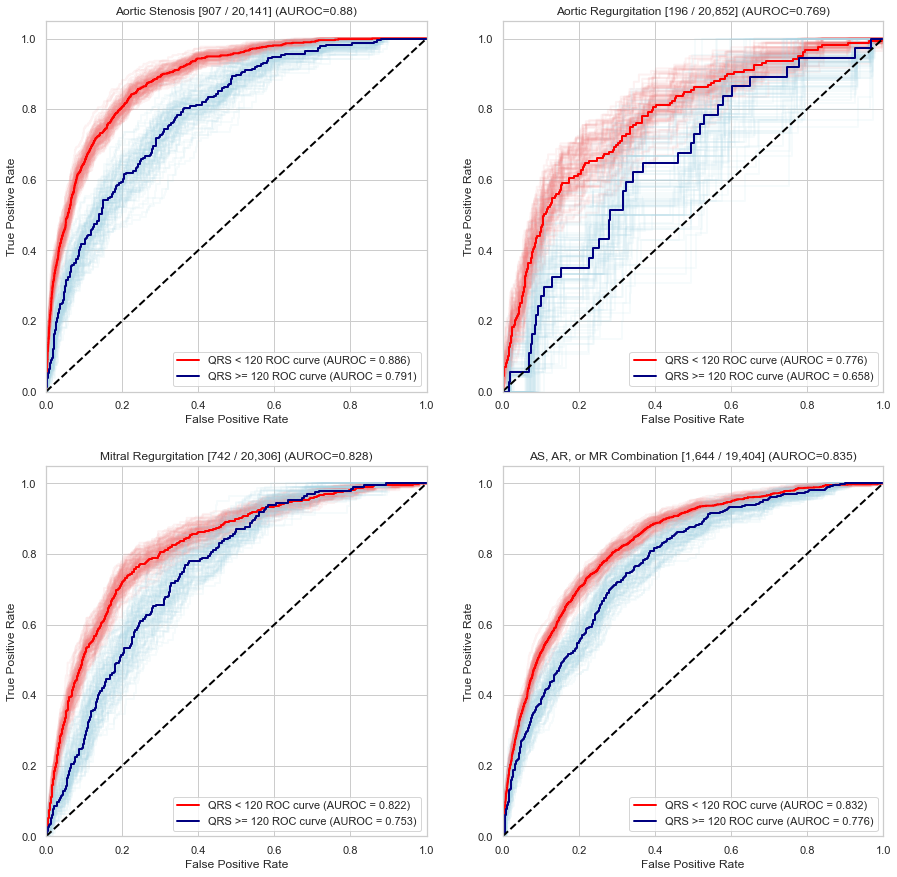

In [77]:
#generate counts of each label number of studies, only non 65 plus
n_AS, n_AI, n_MR, n_AS_AI_MR = 0,0,0,0
for study in study_name:
    if '65plus' not in study:
        if study=='AS':
            n_AS+=1
        if study.startswith('AI'):
            n_AI+=1
        if study.startswith('MR'):
            n_MR+=1
        if 'AS_AI_MR' in study:
            n_AS_AI_MR+=1
            
#generate color counts (must make separate for age 65 if we want the two studies that only differ from age to have same color)
c_AS, c_AI, c_MR, c_AS_AI_MR = 0,0,0,0
c65_AS, c65_AI, c65_MR, c65_AS_AI_MR = 0,0,0,0

print(lstFiles)
print(study_name)

columns = ['y','y_pred_proba']
#a = plt.figure(figsize=(15, 15), subplots = [1,2])  
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for file, ax in zip(lstFiles,ax.flatten()):
    #plt.figure(figsize=(15, 15))  
    print('\n',file)
    df = pd.read_csv(file, names=columns)
    df = pd.concat([test_race_ethnicity, df], axis = 1)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))

    # calculate scores
    print('All scores')
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    auroc_total = auroc
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    # test_pred[test_pred['QRSDuration'] <= 120]['QRSDuration'].value_counts()
    df_qrs_less_than_120 = df[df['QRSDuration'] < 120].reset_index().copy()
    df_qrs_greater_than_120 = df[df['QRSDuration'] >= 120].reset_index().copy()

    print(df_qrs_less_than_120.shape)
    print(df_qrs_greater_than_120.shape)
    
    # QRS <= 120
    fpr_boot, tpr_boot, _ = boot(df_qrs_less_than_120)
    
    # plotting 
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightcoral',
                 lw=lw, alpha = .1)
        
    # calculate scores
    print('QRS < 120')
    y_true,y_scores = df_qrs_less_than_120['y'],df_qrs_less_than_120['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    
    # QRS >= 120 
    fpr_boot, tpr_boot, _ = boot(df_qrs_greater_than_120)
    
    # plotting 
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightblue',
                 lw=lw, alpha = .1)
    
   
    # QRS < 120 acual ROC curve
    ax.plot(fpr, tpr, color='red',
         lw=lw, label='QRS < 120 ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    # calculate scores
    print('QRS >= 120')
    y_true,y_scores = df_qrs_greater_than_120['y'],df_qrs_greater_than_120['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    
    titlename = file.partition('Eval_')[2].partition('_2022')[0] + f' [{pos_count} / {neg_count}]' + f' (AUROC={auroc_total})'
    titlename = titlename.replace("AS_AI_MR", "AS, AR, or MR")
    titlename = titlename.replace("_", " ")
    titlename = titlename.replace("Aortic Insufficiency", "Aortic Regurgitation")
    print(titlename)
    
    ax.plot(fpr, tpr, color='navy',
         lw=lw, label='QRS >= 120 ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(titlename)
    ax.legend(loc="lower right")
    

In [78]:
fig.savefig('figures/qrs_duration_roc.png')

# Plot results by LBBB/RBBB

In [79]:
test_race_ethnicity['BundleBranchBlock'] = test_race_ethnicity.apply(lambda x: 'RightBundleBranchBlock' if x['RIGHT BUNDLE BRANCH BLOCK'] == 1 
                          else 'LeftBundleBranchBlock' if x['LEFT BUNDLE BRANCH BLOCK'] == 1 
                          else 'No Bundle Branch Block', axis = 1)

factor_var = 'BundleBranchBlock'
target_var = 'AS_AI_MR'
plot_results_by_factor_by_target(test_race_ethnicity, factor_var, target_var)

LeftBundleBranchBlock 

AUROC is: 0.73
Threshold value is: 0.6692591309384145


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 7.9 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 4.2 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

No Bundle Branch Block 

AUROC is: 0.84
Threshold value is: 0.45716718045293103


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 9.6 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 9.9 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

RightBundleBranchBlock 

AUROC is: 0.79
Threshold value is: 0.6141482952187097


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 7.9 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 7.9 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
#generate counts of each label number of studies, only non 65 plus
n_AS, n_AI, n_MR, n_AS_AI_MR = 0,0,0,0
for study in study_name:
    if '65plus' not in study:
        if study=='AS':
            n_AS+=1
        if study.startswith('AI'):
            n_AI+=1
        if study.startswith('MR'):
            n_MR+=1
        if 'AS_AI_MR' in study:
            n_AS_AI_MR+=1
            
#generate color counts (must make separate for age 65 if we want the two studies that only differ from age to have same color)
c_AS, c_AI, c_MR, c_AS_AI_MR = 0,0,0,0
c65_AS, c65_AI, c65_MR, c65_AS_AI_MR = 0,0,0,0

print(lstFiles)
print(study_name)

columns = ['y','y_pred_proba']
#a = plt.figure(figsize=(15, 15), subplots = [1,2])  
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for file, ax in zip(lstFiles,ax.flatten()):
    #plt.figure(figsize=(15, 15))  
    print('\n',file)
    df = pd.read_csv(file, names=columns)
    df = pd.concat([test_race_ethnicity, df], axis = 1)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))

    # calculate scores
    print('All scores')
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    auroc_total = auroc
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    df_no_bundle_branch = df[(df['RIGHT BUNDLE BRANCH BLOCK'] == 0) & (df['LEFT BUNDLE BRANCH BLOCK'] == 0)].reset_index().copy()
    df_left_bundle_branch = df[df['LEFT BUNDLE BRANCH BLOCK'] == 1].reset_index().copy()
    df_right_bundle_branch = df[df['RIGHT BUNDLE BRANCH BLOCK'] == 1].reset_index().copy()
    
    print(df_no_bundle_branch.shape)
    print(df_left_bundle_branch.shape)
    print(df_right_bundle_branch.shape)
    
    # no_bundle_branch
    fpr_boot, tpr_boot, _ = boot(df_no_bundle_branch)
    
    # plotting 
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightgreen',
                 lw=lw, alpha = .1)
        
    # calculate scores
    print('No Bundle')
    y_true,y_scores = df_no_bundle_branch['y'],df_no_bundle_branch['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    ax.plot(fpr, tpr, color='green',
         lw=lw, label='No Bundle Branch ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    
    
     # left_bundle_branch
    fpr_boot, tpr_boot, _ = boot(df_left_bundle_branch)
    
    # plotting 
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightcoral',
                 lw=lw, alpha = .1)
        
    # calculate scores
    print('Left Bundle')
    y_true,y_scores = df_left_bundle_branch['y'],df_left_bundle_branch['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    ax.plot(fpr, tpr, color='red',
         lw=lw, label='Left Bundle Branch ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    
    # Right_bundle_branch
    fpr_boot, tpr_boot, _ = boot(df_right_bundle_branch)
    
    # plotting 
    lw = 2
    for i in range(0,100):
        ax.plot(fpr_boot[i],tpr_boot[i], color='lightblue',
                 lw=lw, alpha = .1)
        
    # calculate scores
    print('Right Bundle')
    y_true,y_scores = df_right_bundle_branch['y'],df_right_bundle_branch['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    print('AUROC is:',roc_auc_score(y_true, y_scores),auc(fpr,tpr))
    auroc = np.round(roc_auc_score(y_true, y_scores),3)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    
    

    
    titlename = file.partition('Eval_')[2].partition('_2022')[0] + f' [{pos_count} / {neg_count}]' + f' (AUROC={auroc_total})'
    titlename = titlename.replace("AS_AI_MR", "AS, AR, or MR")
    titlename = titlename.replace("_", " ")
    titlename = titlename.replace("Aortic Insufficiency", "Aortic Regurgitation")
    print(titlename)
    
    ax.plot(fpr, tpr, color='navy',
         lw=lw, label='Right Bundle Branch ROC curve (AUROC = %0.3f)' % auc(fpr,tpr))
    ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(titlename)
    ax.legend(loc="lower right")


In [81]:
fig.savefig('figures/bundle_branch_roc.png')

# Generate Summary Stats for Table 1 and 2

In [82]:
# Previously, I ran a for loop over each of the 4 target variables
# for y, y_true_col, y_score_col in [('Aortic Stenosis','y_AS','y_pred_AS_proba_sigmoid'), ('Aortic Insufficiency','y_AI','y_pred_AI_proba_sigmoid'), ('Mitral Regurgitation','y_MR','y_pred_MR_proba_sigmoid'), ('Combined','y_AS_AI_MR','y_pred_AS_AI_MR_proba_sigmoid')]:
#     print(y)
#     test_race_ethnicity.name = 'Overall'
#     plot_results(test_race_ethnicity, y_true_col, y_score_col)

# Previous method used a loop. This doesn't seem to work. Plotting comes out wierd and plots are overwritten. Tried fixing by creating a function plot_results_by_factor_by_target and running in different cells.
# Pick target to be any of ['AS','AI','MR','AS_AI_MR']
# Plots get saved in figures/.. dir
factor_var = 'All' # Since we are plotting all the data
target_var = 'AS_AI_MR'
test_race_ethnicity.name = 'All'
plot_results_by_factor_by_target(test_race_ethnicity, factor_var, target_var)

All 

AUROC is: 0.84
Threshold value is: 0.45716718045293103


/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Odds Ratio is: 9.7 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

Odds Ratio is: 10.1 P-Value is: 0.0


<class 'statsmodels.iolib.table.SimpleTable'>

In [83]:
train_df = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/220k_multivalve_train_tabular_metadata_new_ref.csv'))
eval_df = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/13k_multivalve_eval_tabular_metadata_new_ref.csv'))
test_df = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_tabular_metadata_additional_backfill.csv'))

In [84]:
dfs = [train_df,eval_df,test_df]
fours = ['aortic_stenosis_label_four_grade','aortic_insufficiency_label_four_grade','mitral_regurgitation_label_four_grade']
for df in dfs:
    for column in fours:
        df[column] = df[column].fillna(0)
        print(df[column].value_counts(dropna=False))

0.0    183755
3.0     18334
2.0     12091
1.0      7075
Name: aortic_stenosis_label_four_grade, dtype: int64
0.0    162862
1.0     49119
2.0      7898
3.0      1376
Name: aortic_insufficiency_label_four_grade, dtype: int64
0.0    88794
1.0    84270
2.0    38816
3.0     9375
Name: mitral_regurgitation_label_four_grade, dtype: int64
0.0    11351
3.0      852
2.0      475
1.0      272
Name: aortic_stenosis_label_four_grade, dtype: int64
0.0    10532
1.0     2117
2.0      249
3.0       52
Name: aortic_insufficiency_label_four_grade, dtype: int64
0.0    7648
1.0    4086
2.0    1005
3.0     211
Name: mitral_regurgitation_label_four_grade, dtype: int64
0.0    18975
1.0     1166
3.0      623
2.0      284
Name: aortic_stenosis_label_four_grade, dtype: int64
0.0    18504
1.0     2348
2.0      166
3.0       30
Name: aortic_insufficiency_label_four_grade, dtype: int64
0.0    15404
1.0     4902
2.0      601
3.0      141
Name: mitral_regurgitation_label_four_grade, dtype: int64


In [85]:
label_cols = ['aortic_stenosis_label_binary_backfilled',
'aortic_insufficiency_label_binary_backfilled',
'mitral_regurgitation_label_binary_backfilled', 
'AS_AI_MR_label_binary_backfilled',
'aortic_stenosis_label_four_grade',
'aortic_insufficiency_label_four_grade',
'mitral_regurgitation_label_four_grade']
dfs = {'Train':train_df,
       'Eval':eval_df,
       'Test':test_df}

for key,value in dfs.items():
    print('--------------\n',key,'\n--------------')
    for col in label_cols:
        s = value[col]
        counts = s.value_counts()
        percent = s.value_counts(normalize=True)
        percent100 = '(' + s.value_counts(normalize=True,sort=False).mul(100).round(1).astype(str) + ')'
        print(col)
        a = pd.DataFrame({'counts': counts, 'percent': percent100})
        display(a)
    fours = ['aortic_stenosis_label_four_grade','aortic_insufficiency_label_four_grade','mitral_regurgitation_label_four_grade']
    s = value[fours].max(axis=1)
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    percent100 = '(' + s.value_counts(normalize=True,sort=False).mul(100).round(1).astype(str) + ')'
    print('AS_AI_MR_four_grade')
    a = pd.DataFrame({'counts': counts, 'percent': percent100})
    display(a)
    print('\n')

--------------
 Train 
--------------
aortic_stenosis_label_binary_backfilled


counts percent
0.0  190784  (86.2)
1.0   30471  (13.8)

aortic_insufficiency_label_binary_backfilled


counts percent
0.0  212312  (96.0)
1.0    8943   (4.0)

mitral_regurgitation_label_binary_backfilled


counts percent
0.0  174126  (78.7)
1.0   47129  (21.3)

AS_AI_MR_label_binary_backfilled


counts percent
0.0  147872  (66.8)
1.0   73383  (33.2)

aortic_stenosis_label_four_grade


counts percent
0.0  183755  (83.1)
1.0    7075   (3.2)
2.0   12091   (5.5)
3.0   18334   (8.3)

aortic_insufficiency_label_four_grade


counts percent
0.0  162862  (73.6)
1.0   49119  (22.2)
2.0    7898   (3.6)
3.0    1376   (0.6)

mitral_regurgitation_label_four_grade


counts percent
0.0   88794  (40.1)
1.0   84270  (38.1)
2.0   38816  (17.5)
3.0    9375   (4.2)

AS_AI_MR_four_grade


counts percent
0.0   74058  (33.5)
1.0   72906  (33.0)
2.0   46554  (21.0)
3.0   27737  (12.5)



--------------
 Eval 
--------------
aortic_stenosis_label_binary_backfilled


counts percent
0.0   11613  (89.7)
1.0    1337  (10.3)

aortic_insufficiency_label_binary_backfilled


counts percent
0.0   12653  (97.7)
1.0     297   (2.3)

mitral_regurgitation_label_binary_backfilled


counts percent
0.0   11751  (90.7)
1.0    1199   (9.3)

AS_AI_MR_label_binary_backfilled


counts percent
0.0   10539  (81.4)
1.0    2411  (18.6)

aortic_stenosis_label_four_grade


counts percent
0.0   11351  (87.7)
1.0     272   (2.1)
2.0     475   (3.7)
3.0     852   (6.6)

aortic_insufficiency_label_four_grade


counts percent
0.0   10532  (81.3)
1.0    2117  (16.3)
2.0     249   (1.9)
3.0      52   (0.4)

mitral_regurgitation_label_four_grade


counts percent
0.0    7648  (59.1)
1.0    4086  (31.6)
2.0    1005   (7.8)
3.0     211   (1.6)

AS_AI_MR_four_grade


counts percent
0.0    6632  (51.2)
1.0    3896  (30.1)
2.0    1343  (10.4)
3.0    1079   (8.3)



--------------
 Test 
--------------
aortic_stenosis_label_binary_backfilled


counts percent
0.0   20141  (95.7)
1.0     907   (4.3)

aortic_insufficiency_label_binary_backfilled


counts percent
0.0   20852  (99.1)
1.0     196   (0.9)

mitral_regurgitation_label_binary_backfilled


counts percent
0.0   20306  (96.5)
1.0     742   (3.5)

AS_AI_MR_label_binary_backfilled


counts percent
0.0   19404  (92.2)
1.0    1644   (7.8)

aortic_stenosis_label_four_grade


counts percent
0.0   18975  (90.2)
1.0    1166   (5.5)
3.0     623   (3.0)
2.0     284   (1.3)

aortic_insufficiency_label_four_grade


counts percent
0.0   18504  (87.9)
1.0    2348  (11.2)
2.0     166   (0.8)
3.0      30   (0.1)

mitral_regurgitation_label_four_grade


counts percent
0.0   15404  (73.2)
1.0    4902  (23.3)
2.0     601   (2.9)
3.0     141   (0.7)

AS_AI_MR_four_grade


counts percent
0.0   13593  (64.6)
1.0    5811  (27.6)
2.0     871   (4.1)
3.0     773   (3.7)

In [86]:
for key,value in dfs.items():
    print('----------------------------\n',key,'\n----------------------------')
    display(value.describe(percentiles=[0.025, 0.975]).apply(lambda s: s.apply('{0:.2f}'.format)).T)

----------------------------
 Train 
----------------------------


count           mean  \
TestID                                              221255.00     1916079.72   
PatientID                                           221255.00  1023185484.09   
Gender                                              221255.00           0.48   
Race                                                210467.00           4.19   
Ventricular_Pacing_Present                          221255.00           0.00   
Poor_Data_Quality                                   221255.00           0.00   
aortic_stenosis_label_binary                        221255.00           0.14   
mitral_regurgitation_label_binary                   221255.00           0.21   
aortic_insufficiency_label_binary                   221255.00           0.04   
aortic_stenosis_label_binary_backfilled             221255.00           0.14   
aortic_insufficiency_label_binary_backfilled        221255.00           0.04   
mitral_regurgitation_label_binary_backfilled        221255.00           0.21   
AS_AI_MR_label_binary                               221255.00           0.33   
AS_AI_MR_label_binary_backfilled                    221255.00           0.33   
PatientAge_Years                                    221255.00          62.59   
Poor_Data_Quality_Present                           221255.00           0.00   
AtrialRate                                          221255.00          89.85   
VentricularRate                                     221255.00          81.62   
P_RInterval                                         221255.00         143.69   
QRSDuration                                         221255.00          97.72   
QTCCalculation                                      221255.00         451.59   
QTcFredericia                                       127353.00         436.71   
AtrialRate_standard_scale                           221255.00          -0.00   
VentricularRate_standard_scale                      221255.00          -0.00   
P_RInterval_standard_scale                          221255.00          -0.00   
QRSDuration_standard_scale                          221255.00           0.00   
QTCCalculation_standard_scale                       221255.00          -0.00   
PatientAge_Years_standard_scale                     221255.00          -0.00   
SINUS TACHYCARDIA                                   221255.00           0.12   
OCCASIONAL PREMATURE VENTRICULAR COMPLEXES          221255.00           0.02   
POSSIBLE LEFT ATRIAL ENLARGEMENT                    221255.00           0.13   
LOW VOLTAGE QRS                                     221255.00           0.05   
CANNOT RULE OUT ANTERIOR INFARCT                    221255.00           0.03   
ABNORMAL ECG                                        221255.00           0.73   
NO PREVIOUS ECGS AVAILABLE                          221242.00           0.13   
ANTERIOR INFARCT                                    221255.00           0.02   
WHEN COMPARED                                       221242.00           0.86   
DX STATEMENT IGNORED INCLUDES NO LONGER PRESENT     221242.00           0.11   
SINUS BRADYCARDIA                                   221255.00           0.10   
OTHERWISE NORMAL ECG                                221255.00           0.06   
NO SIGNIFICANT CHANGE WAS FOUND                     221242.00           0.39   
SINUS ARRHYTHMIA                                    221255.00           0.03   
RSR OR QR PATTERN IN V1 AND/OR V2 SUGGESTS RIGH...  221255.00           0.02   
BORDERLINE ECG                                      221255.00           0.07   
NORMAL SINUS RHYTHM                                 221255.00           0.65   
OCCASIONAL PREMATURE SUPRAVENTRICULAR COMPLEXES     221242.00           0.00   
NORMAL ECG                                          221255.00           0.12   
CANNOT RULE OUT INFERIOR INFARCT                    221255.00           0.02   
POOR DATA QUALITY                                   221242.00           0.00   
LEFT VENTRICULAR HYPERTROPHY                        2212

----------------------------
 Eval 
----------------------------


count           mean  \
TestID                                              12950.00     2098154.59   
PatientID                                           12950.00  1032654872.34   
Gender                                              12950.00           0.49   
Race                                                11832.00           4.21   
Ventricular_Pacing_Present                          12950.00           0.00   
Poor_Data_Quality                                   12950.00           0.00   
aortic_stenosis_label_binary                        12950.00           0.10   
mitral_regurgitation_label_binary                   12950.00           0.09   
aortic_insufficiency_label_binary                   12950.00           0.02   
aortic_stenosis_label_binary_backfilled             12950.00           0.10   
aortic_insufficiency_label_binary_backfilled        12950.00           0.02   
mitral_regurgitation_label_binary_backfilled        12950.00           0.09   
AS_AI_MR_label_binary                               12950.00           0.19   
AS_AI_MR_label_binary_backfilled                    12950.00           0.19   
PatientAge_Years                                    12950.00          63.60   
Poor_Data_Quality_Present                           12950.00           0.00   
AtrialRate                                          12950.00          86.85   
VentricularRate                                     12950.00          79.58   
P_RInterval                                         12950.00         144.59   
QRSDuration                                         12950.00          96.63   
QTCCalculation                                      12950.00         448.50   
QTcFredericia                                        9585.00         432.16   
AtrialRate_standard_scale                           12950.00           0.00   
VentricularRate_standard_scale                      12950.00           0.00   
P_RInterval_standard_scale                          12950.00          -0.00   
QRSDuration_standard_scale                          12950.00           0.00   
QTCCalculation_standard_scale                       12950.00          -0.00   
PatientAge_Years_standard_scale                     12950.00          -0.00   
SINUS TACHYCARDIA                                   12950.00           0.10   
OCCASIONAL PREMATURE VENTRICULAR COMPLEXES          12950.00           0.02   
POSSIBLE LEFT ATRIAL ENLARGEMENT                    12950.00           0.12   
LOW VOLTAGE QRS                                     12950.00           0.05   
CANNOT RULE OUT ANTERIOR INFARCT                    12950.00           0.03   
ABNORMAL ECG                                        12950.00           0.67   
NO PREVIOUS ECGS AVAILABLE                          12950.00           0.21   
ANTERIOR INFARCT                                    12950.00           0.02   
WHEN COMPARED                                       12950.00           0.77   
DX STATEMENT IGNORED INCLUDES NO LONGER PRESENT     12950.00           0.11   
SINUS BRADYCARDIA                                   12950.00           0.11   
OTHERWISE NORMAL ECG                                12950.00           0.07   
NO SIGNIFICANT CHANGE WAS FOUND                     12950.00           0.35   
SINUS ARRHYTHMIA                                    12950.00           0.03   
RSR OR QR PATTERN IN V1 AND/OR V2 SUGGESTS RIGH...  12950.00           0.02   
BORDERLINE ECG                                      12950.00           0.08   
NORMAL SINUS RHYTHM                                 12950.00           0.66   
OCCASIONAL PREMATURE SUPRAVENTRICULAR COMPLEXES     12950.00           0.00   
NORMAL ECG                                          12950.00           0.15   
CANNOT RULE OUT INFERIOR INFARCT                    12950.00           0.01   
POOR DATA QUALITY                                   12950.00           0.00   
LEFT VENTRICULAR HYPERTROPHY                        12950.00           0.10   
INFERIOR INFARCT          

----------------------------
 Test 
----------------------------


count           mean  \
TestID                                        21048.00     2522514.51   
PatientID                                     21048.00  1067022344.92   
Gender                                        21048.00           0.50   
Race                                          12163.00           4.33   
aortic_stenosis_label_four_grade              21048.00           0.17   
aortic_insufficiency_label_four_grade         21048.00           0.13   
mitral_regurgitation_label_four_grade         21048.00           0.31   
aortic_stenosis_label_binary                  17497.00           0.05   
mitral_regurgitation_label_binary             19414.00           0.04   
aortic_insufficiency_label_binary             19632.00           0.01   
aortic_stenosis_label_binary_backfilled       21048.00           0.04   
aortic_insufficiency_label_binary_backfilled  21048.00           0.01   
mitral_regurgitation_label_binary_backfilled  21048.00           0.04   
AS_AI_MR_label_binary                         19902.00           0.08   
AS_AI_MR_label_binary_backfilled              21048.00           0.08   
QRSDuration                                   21048.00          92.84   
RIGHT BUNDLE BRANCH BLOCK                     20984.00           0.06   
LEFT BUNDLE BRANCH BLOCK                      20984.00           0.02   
days_since_echo                               21048.00         -77.68   
PatientAge_Years                              21012.00          61.52   

                                                       std            min  \
TestID                                           695914.96     1143854.00   
PatientID                                     107495409.63  1000000178.00   
Gender                                                0.50           0.00   
Race                                                  4.64           0.00   
aortic_stenosis_label_four_grade                      0.59           0.00   
aortic_insufficiency_label_four_grade                 0.37           0.00   
mitral_regurgitation_label_four_grade                 0.56           0.00   
aortic_stenosis_label_binary                          0.22           0.00   
mitral_regurgitation_label_binary                     0.19           0.00   
aortic_insufficiency_label_binary                     0.10           0.00   
aortic_stenosis_label_binary_backfilled               0.20           0.00   
aortic_insufficiency_label_binary_backfilled          0.10           0.00   
mitral_regurgitation_label_binary_backfilled          0.18           0.00   
AS_AI_MR_label_binary                                 0.28           0.00   
AS_AI_MR_label_binary_backfilled                      0.27           0.00   
QRSDuration                                          20.29           0.00   
RIGHT BUNDLE BRANCH BLOCK                             0.24           0.00   
LEFT BUNDLE BRANCH BLOCK                              0.15           0.00   
days_since_echo                                     113.89        -365.00   
PatientAge_Years                                     17.53           0.00   

                                                       2.5%            50%  \
TestID                                           1510838.32     2408502.00   
PatientID                                     1000619042.52  1009046963.00   
Gender                                                 0.00           0.00   
Race                                                   0.00           3.00   
aortic_stenosis_label_four_grade                       0.00           0.00   
aortic_insufficiency_label_four_grade                  0.00           0.00   
mitral_regurgitation_label_four_grade                  0.00           0.00   
aortic_stenosis_label_binary                           0.00           0.00   
mitral_regurgitation_label_binary                      0.00           0.00   
aortic_insufficiency_label_binary                      0.00           0.00   
aortic_stenosis_label_binary_backfilled

In [87]:
for key,value in dfs.items():
    print('----------------------------\n',key,'(Male=0, Female=1)\n----------------------------')
    display(value.Gender.value_counts(dropna=False))
    display(value.Gender.value_counts(dropna=False,normalize=True))

----------------------------
 Train (Male=0, Female=1)
----------------------------


0.0    115330
1.0    105925
Name: Gender, dtype: int64

0.0    0.521254
1.0    0.478746
Name: Gender, dtype: float64

----------------------------
 Eval (Male=0, Female=1)
----------------------------


0.0    6543
1.0    6407
Name: Gender, dtype: int64

0.0    0.505251
1.0    0.494749
Name: Gender, dtype: float64

----------------------------
 Test (Male=0, Female=1)
----------------------------


0.0    10568
1.0    10480
Name: Gender, dtype: int64

0.0    0.50209
1.0    0.49791
Name: Gender, dtype: float64

In [88]:
age_bins = [0,60,70,80,120]
bincounts = pd.cut(train_df['PatientAge_Years'],bins=age_bins,include_lowest=True).value_counts(dropna=False)
binpct = pd.cut(train_df['PatientAge_Years'],bins=age_bins,include_lowest=True).value_counts(dropna=False,normalize=True)

# Compute Overall Stats Using Bootstrap

In [49]:
n_samples = 1000
test_race_ethnicity.name = 'All'

print('Aortic Stenosis')
as_summary = pd.json_normalize(bootstrap_stats(test_race_ethnicity, 'y_AS', 'y_pred_AS_proba_sigmoid', n_samples))
print('\nMitral Regurgitation')
mr_summary = pd.json_normalize(bootstrap_stats(test_race_ethnicity, 'y_MR', 'y_pred_MR_proba_sigmoid', n_samples))
print('\nAortic Insufficiency')
ai_summary = pd.json_normalize(bootstrap_stats(test_race_ethnicity, 'y_AI', 'y_pred_AI_proba_sigmoid', n_samples))
print('\nCombined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation')
as_mr_ai_summary = pd.json_normalize(bootstrap_stats(test_race_ethnicity, 'y_AS_AI_MR', 'y_pred_AS_AI_MR_proba_sigmoid', n_samples)) 
print('\n\n\n')

Aortic Stenosis
All 



100%|██████████| 1000/1000 [06:12<00:00,  2.68it/s]


0.87 0.9 0.8669916820715248 0.8949386072775464

Mitral Regurgitation
All 



100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]


0.81 0.85 0.8068351190833125 0.8491307165193205

Aortic Insufficiency
All 



100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


0.72 0.81 0.7220325695511524 0.8148359849302759

Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation
All 



100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]

0.82 0.85 0.8221128211597443 0.8480400196977026






In [50]:
as_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Stenosis', x), as_summary.columns))
mr_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Mitral Regurgitation', x), mr_summary.columns))
ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Aortic Insufficiency', x), ai_summary.columns))
as_mr_ai_summary.columns = pd.MultiIndex.from_tuples(map(lambda x: ('Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation', x), as_mr_ai_summary.columns))

overall_summary_stats = pd.concat([as_summary,mr_summary,ai_summary,as_mr_ai_summary], axis = 1)
overall_summary_stats.index = ['Overall']
overall_summary_stats

Aortic Stenosis                                             \
                      n n_positives roc_auc_actual AU-ROC (95% CI)   
Overall           21048         907           0.88     [0.87, 0.9]   

                                        Mitral Regurgitation              \
        odds_ratio_actual   OR (95% CI)                    n n_positives   
Overall              15.2  [12.4, 19.3]                21048         742   

                                                                       \
        roc_auc_actual AU-ROC (95% CI) odds_ratio_actual  OR (95% CI)   
Overall           0.83    [0.81, 0.85]              10.4  [8.2, 13.2]   

        Aortic Insufficiency                                             \
                           n n_positives roc_auc_actual AU-ROC (95% CI)   
Overall                21048         196           0.77    [0.72, 0.81]   

                                        \
        odds_ratio_actual  OR (95% CI)   
Overall               6.7  [4.4, 10.2]   

        Combined Aortic Stenosis, Aortic Regurgitation, and Mitral Regurgitation  \
                                                                               n   
Overall                                              21048                         

                                                                      \
        n_positives roc_auc_actual AU-ROC (95% CI) odds_ratio_actual   
Overall        1644           0.84    [0.82, 0.85]               9.7   

                      
         OR (95% CI)  
Overall  [8.3, 11.3]

# Plot Results For All Data

In [53]:
# Now combine overall, race, ethnicity and save results
race_ethnicity_summary_stats = pd.concat([overall_summary_stats, gender_summary_stats, age_summary_stats,race_summary_stats, ethnicity_summary_stats,bbb_summary_stats,qrs_summary_stats])
race_ethnicity_summary_stats.to_csv('all_subset_summary_stats.csv')

In [ ]:
race_ethnicity_summary_stats

# Look at age breakdown on per study level

In [230]:
for key,value in dfs.items():
    print('--------------\n',key,'\n--------------')
    df=value
    age_bins = [0,60,70,80,120]
    bincounts = pd.cut(df['PatientAge_Years'],bins=age_bins,include_lowest=True).value_counts(dropna=False)
    binpct = pd.cut(df['PatientAge_Years'],bins=age_bins,include_lowest=True).value_counts(dropna=False,normalize=True)
    binpct = '(' + binpct.mul(100).round(1).astype(str) + ')'
    a = pd.DataFrame({'counts': bincounts, 'percent': binpct})
    display(a)

--------------
 Train 
--------------


counts percent
(-0.001, 60.0]   92088  (41.6)
(60.0, 70.0]     53696  (24.3)
(70.0, 80.0]     43669  (19.7)
(80.0, 120.0]    31802  (14.4)

--------------
 Eval 
--------------


counts percent
(-0.001, 60.0]    5087  (39.3)
(60.0, 70.0]      2952  (22.8)
(70.0, 80.0]      2669  (20.6)
(80.0, 120.0]     2242  (17.3)

--------------
 Test 
--------------


counts percent
(-0.001, 60.0]    9246  (43.9)
(60.0, 70.0]      4811  (22.9)
(70.0, 80.0]      3958  (18.8)
(80.0, 120.0]     2991  (14.2)
NaN                 42   (0.2)

# Look at age breakdown on per patient level

In [232]:
for key,value in dfs.items():
    print('--------------\n',key,'\n--------------')
    df=value
    if len(df) > df.PatientID.nunique():
        df = train_df.groupby('PatientID',dropna=False)['PatientAge_Years'].max().reset_index()
    age_bins = [0,60,70,80,120]
    bincounts = pd.cut(df['PatientAge_Years'],bins=age_bins,include_lowest=True).value_counts(dropna=False)
    binpct = pd.cut(df['PatientAge_Years'],bins=age_bins,include_lowest=True).value_counts(dropna=False,normalize=True)
    binpct = '(' + binpct.mul(100).round(1).astype(str) + ')'
    a = pd.DataFrame({'counts': bincounts, 'percent': binpct})
    display(a)

--------------
 Train 
--------------


counts percent
(-0.001, 60.0]   16933  (39.2)
(60.0, 70.0]     10041  (23.3)
(70.0, 80.0]      8763  (20.3)
(80.0, 120.0]     7428  (17.2)

--------------
 Eval 
--------------


counts percent
(-0.001, 60.0]    5087  (39.3)
(60.0, 70.0]      2952  (22.8)
(70.0, 80.0]      2669  (20.6)
(80.0, 120.0]     2242  (17.3)

--------------
 Test 
--------------


counts percent
(-0.001, 60.0]    9246  (43.9)
(60.0, 70.0]      4811  (22.9)
(70.0, 80.0]      3958  (18.8)
(80.0, 120.0]     2991  (14.2)
NaN                 42   (0.2)

In [233]:
s = train_df.groupby('PatientID',dropna=False)['Gender'].max().reset_index()
s = s['Gender']
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = '(' + s.value_counts(normalize=True,sort=False).mul(100).round(1).astype(str) + ')'
a = pd.DataFrame({'counts': counts, 'percent': percent100})
display(a)

counts percent
0.0   21663  (50.2)
1.0   21502  (49.8)

In [234]:
female_index = test_df[test_df.Gender==1].index
male_index = test_df[test_df.Gender==0].index

age18to60 = test_df[(test_df['PatientAge_Years'] >=0) & (df['PatientAge_Years'] <=60)].index
age60to70 = test_df[(test_df['PatientAge_Years'] >=61) & (df['PatientAge_Years'] <=70)].index
age70to80 = test_df[(test_df['PatientAge_Years'] >=71) & (df['PatientAge_Years'] <=80)].index
age80plus = test_df[(test_df['PatientAge_Years'] >=81) & (df['PatientAge_Years'] <=130)].index

age18to65 = test_df[(test_df['PatientAge_Years'] >=0) & (df['PatientAge_Years'] <=65)].index
age65plus = test_df[(test_df['PatientAge_Years'] >=65) & (df['PatientAge_Years'] <=130)].index


In [ ]:
np.save('JACC_REVISIONS_test_female_index.npy',female_index)
np.save('JACC_REVISIONS_test_male_index.npy',male_index)
np.save('JACC_REVISIONS_test_age18to60_index.npy',age18to60)
np.save('JACC_REVISIONS_test_age60to70_index.npy',age60to70)
np.save('JACC_REVISIONS_test_age70to80_index.npy',age70to80)
np.save('JACC_REVISIONS_test_age80plus_index.npy',age80plus)
np.save('JACC_REVISIONS_test_age18to65_index.npy',age18to65)
np.save('JACC_REVISIONS_test_age65plus_index.npy',age65plus)

In [ ]:
base_filename = 'JACC_REVISIONS_test'
base_df = test_df
labels = ['AS_AI_MR_label_binary_backfilled']
sample_prevalences = [0.005,0.01,0.02,0.05,0.1]

In [91]:
for prev in sample_prevalences:
    for label in labels:
        print(prev,label)
        df = adjust_prevalence(base_df, label, prev, minority_class=1)
        index = base_df.reset_index().merge(df, on='filename',how="inner",validate='1:1').set_index('index').index
        assert len(index) == len(df), 'index length incorrect'        
        print(df[label].value_counts(normalize=True,dropna=False))
        print(df[label].value_counts(normalize=False,dropna=False))
        filename = base_filename + '_' + label + '_prev_' + str(prev) + '_index.npy'
        np.save(filename,np.array(index))
        print(f'\n{filename} saved. \n\n')

0.005 AS_AI_MR_label_binary_backfilled
using make_imbalance
0.0    0.994591
1.0    0.005409
Name: AS_AI_MR_label_binary_backfilled, dtype: float64
0.0    19306
1.0      105
Name: AS_AI_MR_label_binary_backfilled, dtype: int64

JACC_REVISIONS_test_AS_AI_MR_label_binary_backfilled_prev_0.005_index.npy saved. 


0.01 AS_AI_MR_label_binary_backfilled
using make_imbalance
0.0    0.989186
1.0    0.010814
Name: AS_AI_MR_label_binary_backfilled, dtype: float64
0.0    19209
1.0      210
Name: AS_AI_MR_label_binary_backfilled, dtype: int64

JACC_REVISIONS_test_AS_AI_MR_label_binary_backfilled_prev_0.01_index.npy saved. 


0.02 AS_AI_MR_label_binary_backfilled
using make_imbalance
0.0    0.97839
1.0    0.02161
Name: AS_AI_MR_label_binary_backfilled, dtype: float64
0.0    19015
1.0      420
Name: AS_AI_MR_label_binary_backfilled, dtype: int64

JACC_REVISIONS_test_AS_AI_MR_label_binary_backfilled_prev_0.02_index.npy saved. 


0.05 AS_AI_MR_label_binary_backfilled
using make_imbalance
0.0    0.94601

In [211]:
base_filename = 'JACC_REVISIONS_test'
base_df = test_df[test_df['PatientAge_Years']>=65]
labels = ['AS_AI_MR_label_binary_backfilled']
sample_prevalences = [0.005,0.01,0.02,0.05,0.1]

In [212]:
for prev in sample_prevalences:
    for label in labels:
        print(prev,label)
        df = adjust_prevalence(base_df, label, prev, minority_class=1)
        index = base_df.reset_index().merge(df, on='filename',how="inner",validate='1:1').set_index('index').index
        assert len(index) == len(df), 'index length incorrect'        
        print(df[label].value_counts(normalize=True,dropna=False))
        print(df[label].value_counts(normalize=False,dropna=False))
        filename = base_filename + '_' + label + '_prev_' + str(prev) + '_age_65_plus_index.npy'
        np.save(filename,np.array(index))
        print(f'{filename} saved. \n')

0.005 AS_AI_MR_label_binary_backfilled
using make_imbalance
0.0    0.994249
1.0    0.005751
Name: AS_AI_MR_label_binary_backfilled, dtype: float64
0.0    8471
1.0      49
Name: AS_AI_MR_label_binary_backfilled, dtype: int64
JACC_REVISIONS_test_AS_AI_MR_label_binary_backfilled_prev_0.005_age_65_plus_index.npy saved. 

0.01 AS_AI_MR_label_binary_backfilled
using make_imbalance
0.0    0.988506
1.0    0.011494
Name: AS_AI_MR_label_binary_backfilled, dtype: float64
0.0    8428
1.0      98
Name: AS_AI_MR_label_binary_backfilled, dtype: int64
JACC_REVISIONS_test_AS_AI_MR_label_binary_backfilled_prev_0.01_age_65_plus_index.npy saved. 

0.02 AS_AI_MR_label_binary_backfilled
using make_imbalance
0.0    0.976932
1.0    0.023068
Name: AS_AI_MR_label_binary_backfilled, dtype: float64
0.0    8343
1.0     197
Name: AS_AI_MR_label_binary_backfilled, dtype: int64
JACC_REVISIONS_test_AS_AI_MR_label_binary_backfilled_prev_0.02_age_65_plus_index.npy saved. 

0.05 AS_AI_MR_label_binary_backfilled
using mak

In [88]:
female_index = test_df[test_df.Gender==1].index
male_index = test_df[test_df.Gender==0].index

age18to60 = test_df[(test_df['PatientAge_Years'] >=0) & (df['PatientAge_Years'] <=60)].index
age60to70 = test_df[(test_df['PatientAge_Years'] >=61) & (df['PatientAge_Years'] <=70)].index
age70to80 = test_df[(test_df['PatientAge_Years'] >=71) & (df['PatientAge_Years'] <=80)].index
age80plus = test_df[(test_df['PatientAge_Years'] >=81) & (df['PatientAge_Years'] <=130)].index

age18to65 = test_df[(test_df['PatientAge_Years'] >=0) & (df['PatientAge_Years'] <=65)].index
age65plus = test_df[(test_df['PatientAge_Years'] >=65) & (df['PatientAge_Years'] <=130)].index


# Now we run the vary_prevalance scripts from ValveNet_v2 back on the Dendrite server 



`
scp -r /Users/pae2/Box/Heart\ Failure\ Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/test_set_subsampling_indices pae2115@10.144.220.25:/home/pae2115/ValveNet_JACC_Revisions
`

`!python /home/pae2115/ValveNet/ValveNet_Multisite_Validation/eval_AS_vary_prevalence.py`

`!python /home/pae2115/ValveNet/ValveNet_Multisite_Validation/eval_AI_vary_prevalence.py`

`!python /home/pae2115/ValveNet/ValveNet_Multisite_Validation/eval_MR_vary_prevalence.py`

`!python /home/pae2115/ValveNet/ValveNet_Multisite_Validation/eval_AS_AI_MR_vary_prevalence.py`


### results found at `Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/eval_vary_prevalence_script_outputs.ipynb`


In [38]:
'''
-------------------Eval_AS_AI_MR_Combination Results-------------------
Loading from validation_data_config <DataConfig(batch_size=64, shuffle=False, sampler=None, data_type=2, pin_memory=True, features_path=/home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_wander_removed_pct_truncated_mean_normalized_waveform_features.npy, labels_path=/home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_27k_test_metadata_no_prev_adjustment_new_ref_pace_removed_poor_quality_removed_wander_removed_pct_truncated_mean_normalized_prosthethics_removed_AS_AI_MR_label.npy, tabular_path=/home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_tabular.npy, features_permute_axes_order=[], labels_permute_axes_order=[]) @a9fd0>


Loading features data from /home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_wander_removed_pct_truncated_mean_normalized_waveform_features.npy
Loading labels data from /home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_27k_test_metadata_no_prev_adjustment_new_ref_pace_removed_poor_quality_removed_wander_removed_pct_truncated_mean_normalized_prosthethics_removed_AS_AI_MR_label.npy
Loading tabular data from /home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_tabular.npy
result shape before permute_axes_order (21048, 1, 2500, 12)
result shape before permute_axes_order (21048,)
result shape before permute_axes_order (21048, 7)

Done loading features data from /home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_wander_removed_pct_truncated_mean_normalized_waveform_features.npy (21048, 1, 2500, 12)
Done loading labels data from /home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_27k_test_metadata_no_prev_adjustment_new_ref_pace_removed_poor_quality_removed_wander_removed_pct_truncated_mean_normalized_prosthethics_removed_AS_AI_MR_label.npy (21048,)
Done loading tabular data from /home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_tabular.npy (21048, 7)
Number of tabular features loaded 7
/home/pae2115/ValveNet_v2/common/data_utils.py:9: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(np_array).float()

Eval label count:  Counter({0.0: 19404, 1.0: 1644})
Eval on: cuda:0
Iteration: [329/329] 100%|████████████████████████████████████████ [00:06<00:00]
Validation Loss (no label weights passed): 0.4700
Validation ROC AUC: 0.8346
Validation AUPRC: 0.3202
Validation Precision at 2% Recall: 0.55
Validation Precision at 5% Recall: 0.5845070422535211
Validation Precision at 10% Recall: 0.5254777070063694
Validation Precision at 20% Recall: 0.45254470426409904
Validation Precision at 50% Recall: 0.30847076461769113
Validation Precision at 75% Recall: 0.21206392851005326
Validation Precision at 90% Recall: 0.152766308835673
Validation f1: 0.3390070921985812


-------------------JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plus Results-------------------
Loading from validation_data_config <DataConfig(batch_size=64, shuffle=False, sampler=None, data_type=2, pin_memory=True, features_path=./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_waveform_array.npy, labels_path=./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_label_array.npy, tabular_path=./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_tabular_array.npy, features_permute_axes_order=[], labels_permute_axes_order=[]) @1e0970>


Loading features data from ./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_waveform_array.npy
Loading labels data from ./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_label_array.npy
Loading tabular data from ./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_tabular_array.npy
result shape before permute_axes_order (9858, 1, 2500, 12)
result shape before permute_axes_order (9858,)
result shape before permute_axes_order (9858, 7)

Done loading features data from ./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_waveform_array.npy (9858, 1, 2500, 12)
Done loading labels data from ./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_label_array.npy (9858,)
Done loading tabular data from ./JACC_REVISION_Eval_AS_AI_MR_JACC_REVISIONS_test_age65plustmp_validation_tabular_array.npy (9858, 7)
Number of tabular features loaded 7

Eval label count:  Counter({0.0: 8514, 1.0: 1344})
Eval on: cuda:0
Iteration: [155/155] 100%|████████████████████████████████████████ [00:03<00:00]
Validation Loss (no label weights passed): 0.6517
Validation ROC AUC: 0.7695
Validation AUPRC: 0.3502
Validation Precision at 2% Recall: 0.5094339622641509
Validation Precision at 5% Recall: 0.5714285714285714
Validation Precision at 10% Recall: 0.5625
Validation Precision at 20% Recall: 0.4786476868327402
Validation Precision at 50% Recall: 0.33465937344604674
Validation Precision at 75% Recall: 0.2518093336660844
Validation Precision at 90% Recall: 0.20026481297583582
Validation f1: 0.36382148311556045
'''

'\n-------------------Eval_AS_AI_MR_Combination Results-------------------\nLoading from validation_data_config <DataConfig(batch_size=64, shuffle=False, sampler=None, data_type=2, pin_memory=True, features_path=/home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_wander_removed_pct_truncated_mean_normalized_waveform_features.npy, labels_path=/home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_27k_test_metadata_no_prev_adjustment_new_ref_pace_removed_poor_quality_removed_wander_removed_pct_truncated_mean_normalized_prosthethics_removed_AS_AI_MR_label.npy, tabular_path=/home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_tabular.npy, features_permute_axes_order=[], labels_permute_axes_order=[]) @a9fd0>\n\n\nLoading features data from /home/pae2115/ValveNet_JACC_Revisions/JACC_REVISION_test_df_newest_ecg_per_pt_wander_removed_pct_truncated_mean_normalized_waveform_features.npy\nLoading labels data from /home/pae2115/ValveNet_JACC_Revision

In [5]:
as_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv')
ai_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv')
mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv')
as_ai_mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv')

lstFiles = [as_path,ai_path,mr_path,as_ai_mr_path]
study_name = [x.partition('Eval_')[2].partition('_2022')[0] for x in lstFiles]
study_name

['Aortic_Stenosis',
 'Aortic_Insufficiency',
 'Mitral_Regurgitation',
 'AS_AI_MR_Combination']

# Test Set AUROC and AUPRC Curves (Fig 3A and 3B)

AUROC is: 0.8804872725564813
Threshold value is: 0.4290496913006215
AUROC is: 0.7687817837666431
Threshold value is: 0.3979350694912722
AUROC is: 0.828017318849102
Threshold value is: 0.45940651160283796
AUROC is: 0.8354910330275293
Threshold value is: 0.45716718045293103


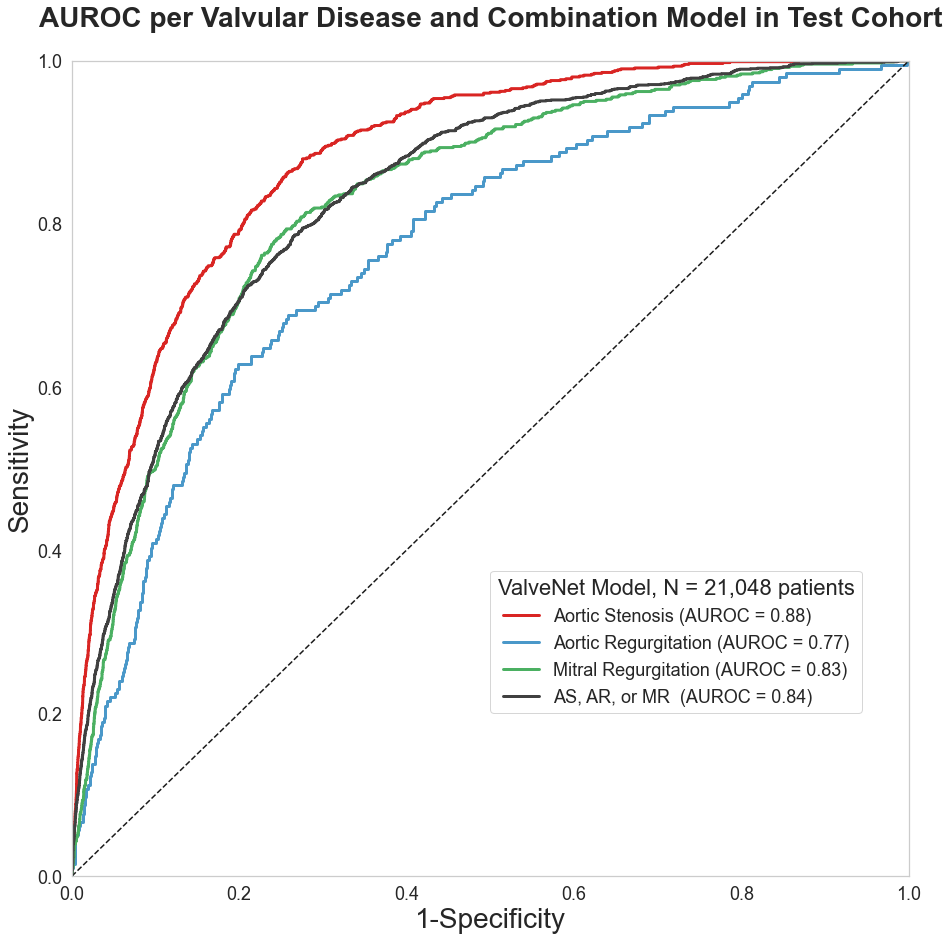

In [10]:
plt.figure(figsize=(15, 15))  

for file in lstFiles:
    df = pd.read_csv(file, names=columns)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    testy, lr_probs = df['y'],df['y_pred_proba'].map(sigmoid)
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    # calculate scores
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    total_count = format(len(df),',d')
    # print(tpr)
    # print(fpr)
    # print(thresholds)
    print('AUROC is:',roc_auc_score(y_true, y_scores))
    auroc = np.round(roc_auc_score(y_true, y_scores),2)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
#     labelname = file.partition('Eval_')[2].partition('_2022')[0] + f' [{pos_count} / {total_count}]' + f' (AUROC={auroc})'
    labelname = file.partition('Eval_')[2].partition('_2022')[0] + f' (AUROC = {auroc})'
    labelname = labelname.replace("AS_AI_MR", "AS, AR, or MR")
    labelname = labelname.replace("_", " ")
    labelname = labelname.replace("Combination", "")
#     labelname = labelname.replace("AI", "Aortic Regurgitation")
#     labelname = labelname.replace("AS", "Aortic Stenosis")
#     labelname = labelname.replace("MR", "Mitral Regurgitation")
    labelname = labelname.replace("Aortic Insufficiency", "Aortic Regurgitation")
    marker=','
    linewidth=3
    linestyle='-'
    if labelname.startswith('Aortic Stenosis'):
        colorwheel=pl.cm.Reds(np.linspace(0.7,n_AS))
        color=colorwheel[c_AS]
    if labelname.startswith('Aortic Regurgitation'):
        colorwheel=pl.cm.Blues(np.linspace(0.6,n_AI))
        color=colorwheel[c_AI]
    if labelname.startswith('Mitral Regurgitation'):
        colorwheel=pl.cm.Greens(np.linspace(0.6,n_MR))
        color=colorwheel[c_MR]
    if 'AS, AR, or MR' in labelname:
        colorwheel=pl.cm.Greys(np.linspace(0.8,n_AS_AI_MR))
        color=colorwheel[c_AS_AI_MR]
    plt.plot(fpr, tpr, label=labelname,linewidth=linewidth,color=color,marker=marker,linestyle=linestyle)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot( [0,1],[0,1],'--k') #reference line dashed black
plt.grid(False) #remove gridlines
plt.xlabel('1-Specificity',fontsize=28)
plt.ylabel('Sensitivity',fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('AUROC per Valvular Disease and Combination Model in Test Cohort',fontsize=28,fontweight="bold",pad = 34)
# show the legend
res = (format(len(df),',d'))
plt.legend(title=f'ValveNet Model, N = {total_count} patients',fontsize=18, loc=(.50,.20))
plt.setp(plt.gca().get_legend().get_title(), fontsize='22') #change legend title fontsize

plt.savefig('figures/Test_ROC.png')

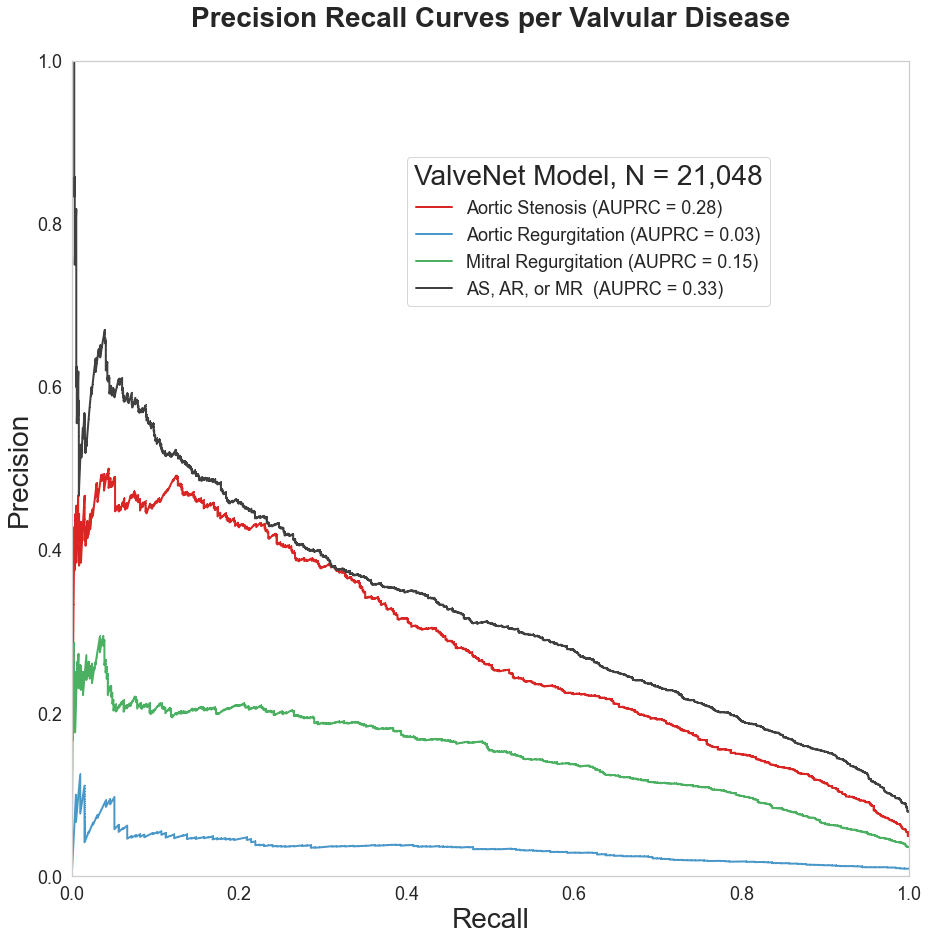

<Figure size 432x288 with 0 Axes>

In [9]:
from itertools import cycle
columns = ['y','y_pred_proba']
plt.figure(figsize=(15, 15))
#generate counts of each label number of studies, only non 65 plus
n_AS, n_AI, n_MR, n_AS_AI_MR = 0,0,0,0
for study in study_name:
    if '65plus' not in study:
        if study=='AS':
            n_AS+=1
        if study.startswith('AI'):
            n_AI+=1
        if study.startswith('MR'):
            n_MR+=1
        if 'AS_AI_MR' in study:
            n_AS_AI_MR+=1
#generate color counts (must make separate for age 65 if we want the two studies that only differ from age to have same color)
c_AS, c_AI, c_MR, c_AS_AI_MR = 0,0,0,0
c65_AS, c65_AI, c65_MR, c65_AS_AI_MR = 0,0,0,0

for file in lstFiles:
    df = pd.read_csv(file, names=columns)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    testy, lr_probs = df['y'],df['y_pred_proba'].map(sigmoid)
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    auprc = np.round(average_precision_score(testy, lr_probs),2)
    total_count = format(len(df),',d')
    # calculate scores
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    # summarize scores
#     print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
#     labelname = file.partition('Eval_')[2].partition('_2022')[0] + f' [{pos_count} / {total_count}]' + f' (AUPRC={auprc})'
    labelname = file.partition('Eval_')[2].partition('_2022')[0] + f' (AUPRC = {auprc})'
    labelname = labelname.replace("AS_AI_MR", "AS, AR, or MR")
    labelname = labelname.replace("_", " ")
    labelname = labelname.replace("Combination", "")
#     labelname = labelname.replace("AI", "Aortic Regurgitation")
#     labelname = labelname.replace("AS", "Aortic Stenosis")
#     labelname = labelname.replace("MR", "Mitral Regurgitation")
    labelname = labelname.replace("Aortic Insufficiency", "Aortic Regurgitation")
    linestyle='solid'
    marker=','
    linewidth=2
    if labelname.startswith('Aortic Stenosis'):
        colorwheel=pl.cm.Reds(np.linspace(0.7,n_AS))
        color=colorwheel[c_AS]
    if labelname.startswith('Aortic Regurgitation'):
        colorwheel=pl.cm.Blues(np.linspace(0.6,n_AI))
        color=colorwheel[c_AI]
    if labelname.startswith('Mitral Regurgitation'):
        colorwheel=pl.cm.Greens(np.linspace(0.6,n_MR))
        color=colorwheel[c_MR]
    if 'AS, AR, or MR' in labelname:
        colorwheel=pl.cm.Greys(np.linspace(0.8,n_AS_AI_MR))
        color=colorwheel[c_AS_AI_MR]
    plt.plot(lr_recall, lr_precision, marker=marker, markersize=3, label=labelname,
               color=color,linestyle=linestyle,linewidth=linewidth)

# no_skill = len(testy[testy==1]) / len(testy) 
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# axis labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall',fontsize=28)
plt.ylabel('Precision',fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(b=None)
plt.title('Precision Recall Curves per Valvular Disease',fontsize=28,fontweight="bold",pad = 34)
# show the legend
plt.legend(title=f'ValveNet Model, N = {total_count}', fontsize=18, loc=(.4,.7),ncol=1)
plt.setp(plt.gca().get_legend().get_title(), fontsize='28') #change legend title fontsize
# show the plot
plt.show()

plt.savefig('figures/Test_AUPRC.png')

# Compute a Logistic Regression Model using Tabular Data

In [193]:
CONTINUOUS_COLUMNS = ['PatientAge_Years','QRSDuration','P_RInterval','QTCCalculation','VentricularRate','AtrialRate']

CONTINUOUS_COLUMNS_STANDARD_SCALE = ['PatientAge_Years_standard_scale','QRSDuration_standard_scale','P_RInterval_standard_scale','QTCCalculation_standard_scale',
                      'VentricularRate_standard_scale','AtrialRate_standard_scale']

TABULAR_COLUMNS_TRUNCATED = CONTINUOUS_COLUMNS_STANDARD_SCALE + ['Gender']

In [198]:
logit_train_df = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/220k_multivalve_train_tabular_metadata_new_ref.csv'))
logit_test_df = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISION_test_df_metadata_available.csv'))

/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,53,57,58,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [199]:
train_tabular = logit_train_df[TABULAR_COLUMNS_TRUNCATED]
test_tabular = logit_test_df[TABULAR_COLUMNS_TRUNCATED]
train_label = logit_train_df['AS_AI_MR_label_binary_backfilled']
test_label = logit_test_df['AS_AI_MR_label_binary_backfilled']

Accuracy of logistic regression classifier on test set: 0.84
AUC: 0.663
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     19404
         1.0       0.23      0.45      0.31      1644

    accuracy                           0.84     21048
   macro avg       0.59      0.66      0.61     21048
weighted avg       0.89      0.84      0.86     21048



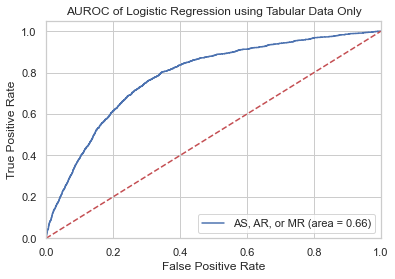

AUC: 0.663


Text(0.5, 257.44, 'Predicted label')

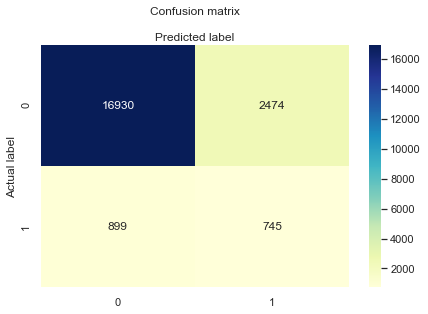

In [210]:
import statsmodels.api as sm

X_train = train_tabular
X_test = test_tabular
y_train = train_label
y_test = test_label

X_train_constant = sm.add_constant(X_train)
# logit_model_constant = sm.Logit(y_train, X_train_constant) #tried with and without adding a constant
# result_1 = logit_model_constant.fit()
# print (result_1.summary())

# params = result_1.params
# conf = result_1.conf_int()
# conf['OR'] = params
# conf.columns = ['2.5%', '97.5%', 'OR']
# print (np.exp(conf))

# X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y_Amyloid_Yes_No, test_size=0.5, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train_constant, y_train)

X_test_constant = sm.add_constant(X_test)

y_pred = logreg.predict(X_test_constant)

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_constant))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_constant)[:,1])

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_constant, y_test)))

print('AUC: %.3f' % logit_roc_auc)

print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.to_csv('logit_model_stats.csv')

plt.figure()
plt.plot(fpr, tpr, label='AS, AR, or MR (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC of Logistic Regression using Tabular Data Only')
plt.legend(loc="lower right")
plt.savefig('figures/Logit_ROC.png')
plt.show()

print('AUC: %.3f' % logit_roc_auc)

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')





In [208]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     19404
         1.0       0.23      0.45      0.31      1644

    accuracy                           0.84     21048
   macro avg       0.59      0.66      0.61     21048
weighted avg       0.89      0.84      0.86     21048



# How much earlier was a patient's first ECG than their first echo among severe AS patients?

In [189]:
dates_dx = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISION_test_df_newest_ecg_per_pt_tabular_metadata.csv'))
master_muse = pd.read_csv('/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/Master_File_MUSE_Pt_List.csv')

/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,53,57,58,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [190]:
severe_as_only['first_AS_dx_DATE_TIME_CREATED'] = pd.to_datetime(severe_as_only['first_AS_dx_DATE_TIME_CREATED'])

<ipython-input-190-83008afd2160>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severe_as_only['first_AS_dx_DATE_TIME_CREATED'] = pd.to_datetime(severe_as_only['first_AS_dx_DATE_TIME_CREATED'])


In [191]:
master_muse['AcquisitionDateTime_DT'] = pd.to_datetime(master_muse['AcquisitionDateTime_DT'])

In [192]:
pt_as_cols = ['PatientID','first_AS_dx_DATE_TIME_CREATED']
pt_as = severe_as_only[pt_as_cols]
pt_as = pt_as.drop_duplicates()
muse_pt_as = master_muse.merge(pt_as,how='inner',on='PatientID')

In [193]:
muse_pt_as['days_since_dx'] = (muse_pt_as['AcquisitionDateTime_DT'] - muse_pt_as['first_AS_dx_DATE_TIME_CREATED']).dt.days #negative means ECG was prior to echo

In [194]:
muse_pt_as = muse_pt_as[muse_pt_as['days_since_dx']<3]

In [195]:
muse_pt_as_grouped = muse_pt_as.groupby('PatientID')['days_since_dx'].min()

In [196]:
muse_pt_as_grouped.describe(percentiles=[0.025, 0.975])

count      195.000000
mean     -2035.435897
std       3081.856889
min     -11505.000000
2.5%     -9989.500000
50%        -20.000000
97.5%        1.000000
max          1.000000
Name: days_since_dx, dtype: float64

Text(0, 0.5, 'Number of Patients')

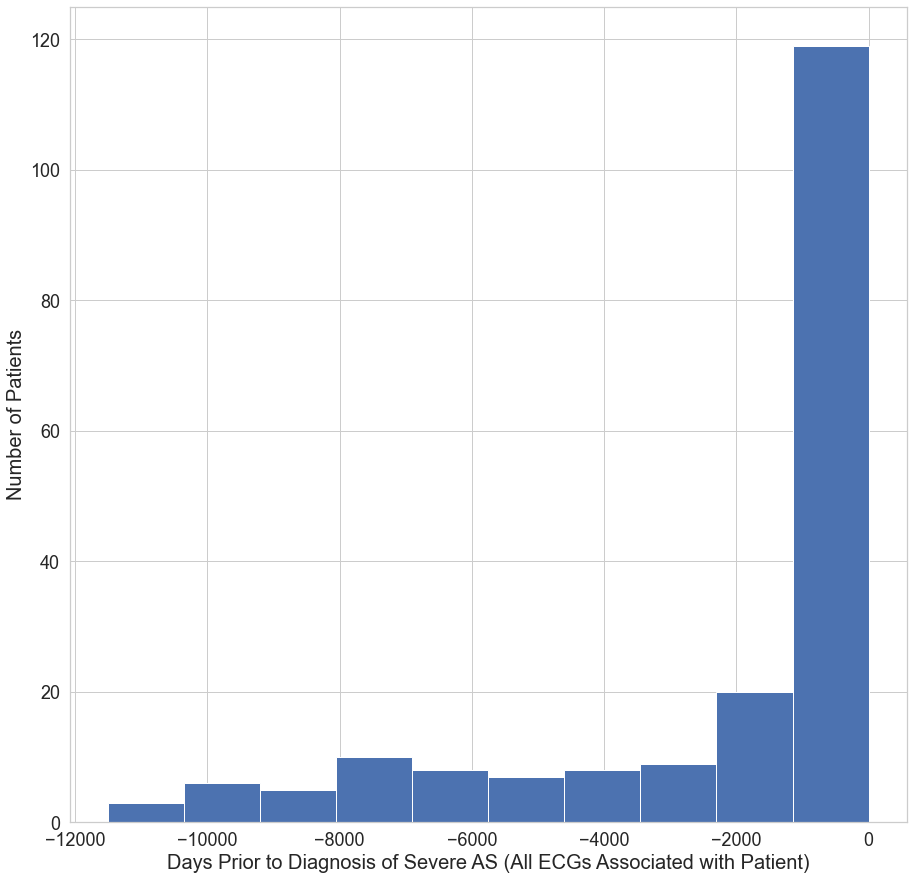

In [197]:
ax = muse_pt_as_grouped.hist(bins=10,figsize=(15,15),xlabelsize=18, ylabelsize=18)
ax.set_xlabel('Days Prior to Diagnosis of Severe AS (All ECGs Associated with Patient)',fontsize=20)
ax.set_ylabel('Number of Patients',fontsize=20)


In [198]:
dates_dx = pd.read_csv(os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISION_test_df_newest_ecg_per_pt_tabular_metadata.csv'))
master_muse = pd.read_csv('/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/Master_File_MUSE_Pt_List.csv')

/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,53,57,58,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [199]:
severe_as_only['first_AS_dx_DATE_TIME_CREATED'] = pd.to_datetime(severe_as_only['first_AS_dx_DATE_TIME_CREATED'])

<ipython-input-199-83008afd2160>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severe_as_only['first_AS_dx_DATE_TIME_CREATED'] = pd.to_datetime(severe_as_only['first_AS_dx_DATE_TIME_CREATED'])


In [200]:
master_muse['AcquisitionDateTime_DT'] = pd.to_datetime(master_muse['AcquisitionDateTime_DT'])

In [201]:
pt_as_cols = ['TestID','first_AS_dx_DATE_TIME_CREATED']
pt_as = severe_as_only[pt_as_cols]
pt_as = pt_as.drop_duplicates()
muse_pt_as = master_muse.merge(pt_as,how='inner',on='TestID')

In [202]:
muse_pt_as['days_since_dx'] = (muse_pt_as['AcquisitionDateTime_DT'] - muse_pt_as['first_AS_dx_DATE_TIME_CREATED']).dt.days #negative means ECG was prior to echo

In [203]:
muse_pt_as = muse_pt_as[muse_pt_as['days_since_dx']<3]

In [204]:
muse_pt_as_grouped = muse_pt_as.groupby('PatientID')['days_since_dx'].min()

In [205]:
muse_pt_as_grouped.describe(percentiles=[0.025, 0.975])

count    388.000000
mean     -22.329897
std       63.600290
min     -359.000000
2.5%    -269.925000
50%       -1.000000
97.5%      0.000000
max        1.000000
Name: days_since_dx, dtype: float64

Text(0, 0.5, 'Number of Patients')

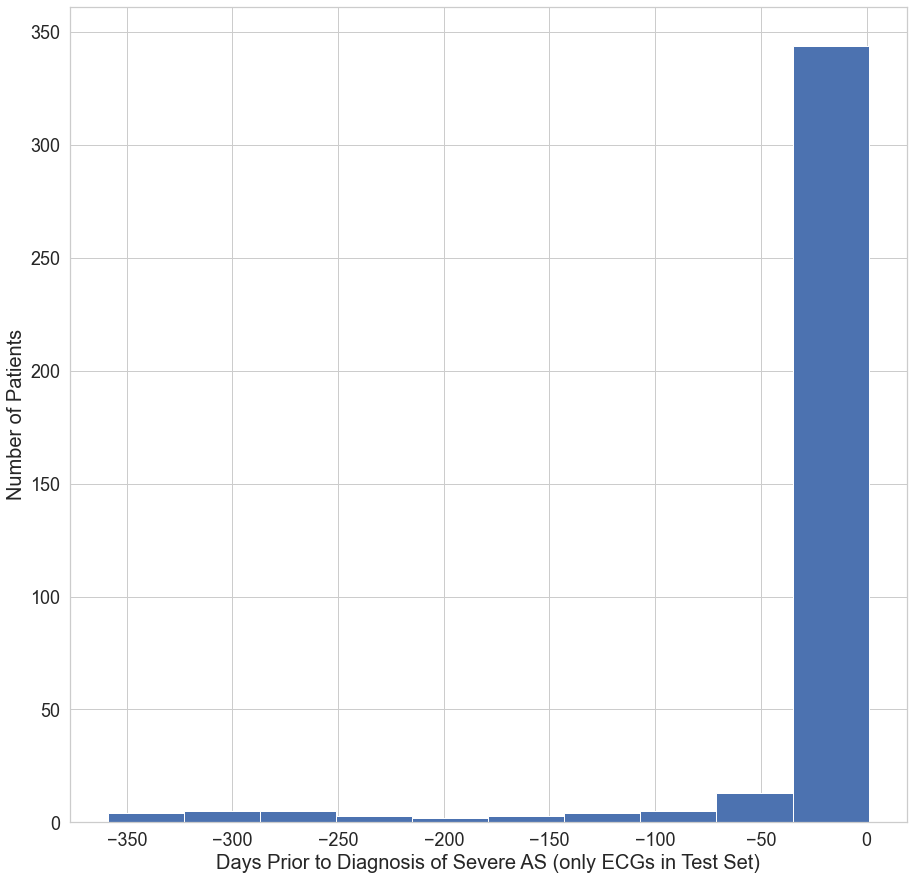

In [206]:
ax = muse_pt_as_grouped.hist(bins=10,figsize=(15,15),xlabelsize=18, ylabelsize=18)
ax.set_xlabel('Days Prior to Diagnosis of Severe AS (only ECGs in Test Set)',fontsize=20)
ax.set_ylabel('Number of Patients',fontsize=20)


# NYP Lawrence Validation with and without Propensity Score Matching
This can be found at `/Users/pae2/Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/NYP_Lawrence/propensity-score-matching-main/propensity_score_matching_v2_ValveNet.ipynb`

# Model Calibration Curves

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


In [9]:
as_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Stenosis_2022-03-03--06:21:48/y_y_pred_roc_0.8805.csv')
ai_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Aortic_Insufficiency_2022-03-03--06:22:25/y_y_pred_roc_0.7688.csv')
mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_Mitral_Regurgitation_2022-03-03--06:23:05/y_y_pred_roc_0.8280.csv')
as_ai_mr_path = os.path.join(box_path_prefix, 'Box/Heart Failure Analytics/Data/MuseLabelGeneration/ValveNet_JACC_Revisions/Dendrite_Transfer/JACC_REVISIONS_Eval_AS_AI_MR_Combination_2022-03-03--06:23:39/y_y_pred_roc_0.8351.csv')

lstFiles = [as_path,ai_path,mr_path,as_ai_mr_path]
study_name = [x.partition('Eval_')[2].partition('_2022')[0] for x in lstFiles]
study_name

['Aortic_Stenosis',
 'Aortic_Insufficiency',
 'Mitral_Regurgitation',
 'AS_AI_MR_Combination']

Logistic:
	Brier: 0.035
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes:
	Brier: 0.035
	Precision: 0.543
	Recall: 0.041
	F1: 0.077

Naive Bayes + Sigmoid:
	Brier: 0.036
	Precision: 0.471
	Recall: 0.107
	F1: 0.174



/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


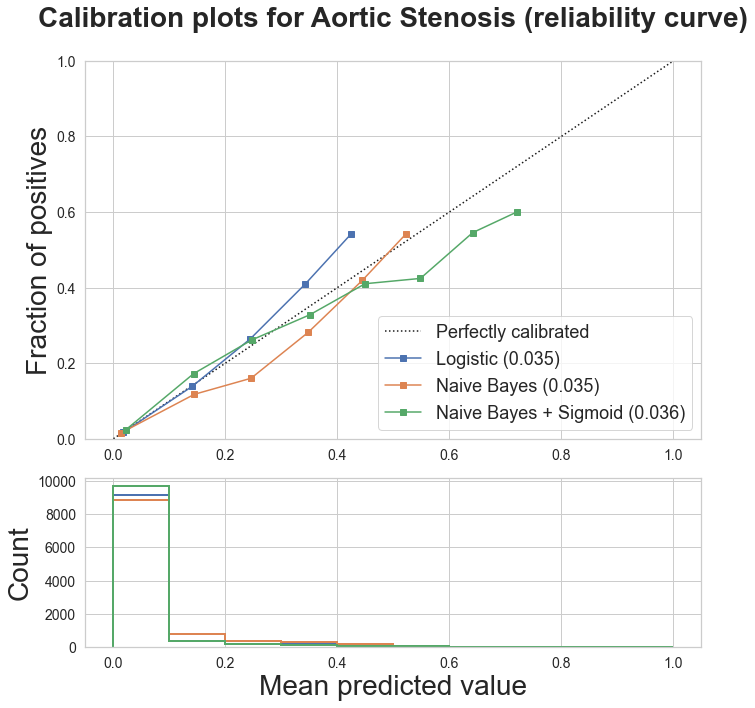

Logistic:
	Brier: 0.009
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes:
	Brier: 0.009
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes + Sigmoid:
	Brier: 0.009
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


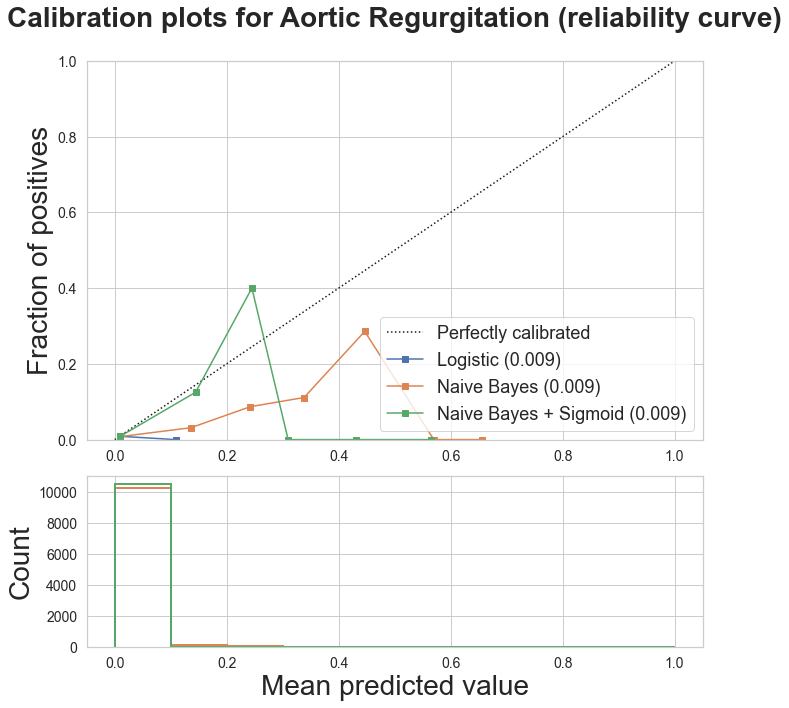

Logistic:
	Brier: 0.031
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes:
	Brier: 0.031
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes + Sigmoid:
	Brier: 0.031
	Precision: 0.250
	Recall: 0.005
	F1: 0.011



/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pae2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


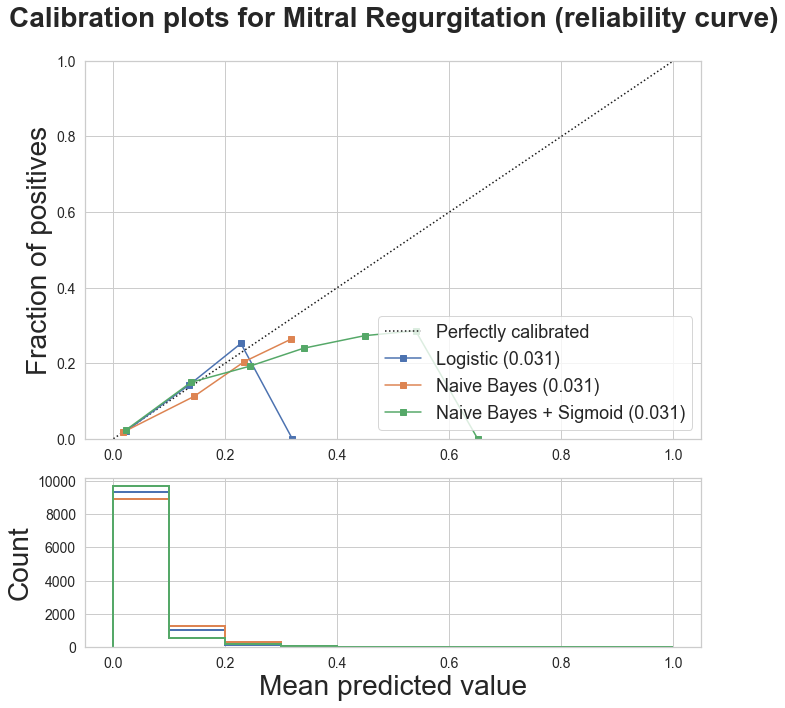

Logistic:
	Brier: 0.061
	Precision: 0.690
	Recall: 0.036
	F1: 0.068

Naive Bayes:
	Brier: 0.061
	Precision: 0.558
	Recall: 0.071
	F1: 0.126

Naive Bayes + Sigmoid:
	Brier: 0.062
	Precision: 0.492
	Recall: 0.117
	F1: 0.189



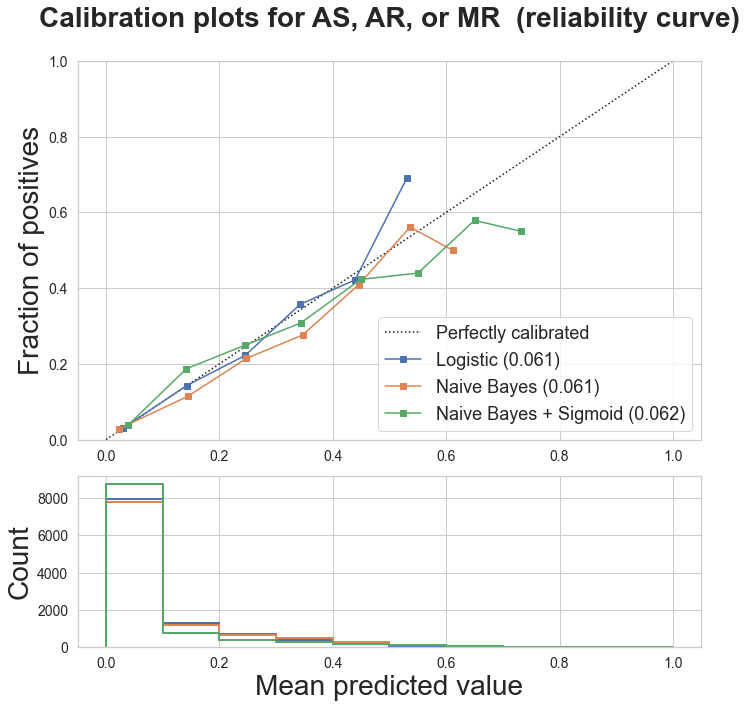

In [44]:
columns = ['y','y_pred_proba']

for path in lstFiles:
    df = pd.read_csv(path, names=columns)
    X = df['y_pred_proba'].map(sigmoid)
    y = df['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    X_train = np.array(X_train).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, 1)

    def plot_calibration_curve(est, name, fig_index):
        """Plot calibration curve for est w/o and with calibration. """
        # Calibrated with isotonic calibration
#         isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

        # Calibrated with sigmoid calibration
        sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

        # Logistic regression with no calibration as baseline
        lr = LogisticRegression(C=1.)

        fig = plt.figure(fig_index, figsize=(10, 10))
        
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((3, 1), (2, 0))
        ax1.tick_params(axis='both', which='major', labelsize=14)
        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        for clf, name in [(lr, 'Logistic'),
                          (est, name),
#                           (isotonic, name + ' + Isotonic'),
                          (sigmoid, name + ' + Sigmoid')]:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            if hasattr(clf, "predict_proba"):
                prob_pos = clf.predict_proba(X_test)[:, 1]
            else:  # use decision function
                prob_pos = clf.decision_function(X_test)
                prob_pos = \
                    (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

            clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
            print("%s:" % name)
            print("\tBrier: %1.3f" % (clf_score))
            print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
            print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
            print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

            fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)

            ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)

            ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2) 
        ax1.set_ylabel("Fraction of positives",fontsize=28)

        ax1.set_ylim([0, 1])

        ax1.legend(loc="lower right",fontsize=18)
        file = path
        labelname = file.partition('Eval_')[2].partition('_2022')[0]
        labelname = labelname.replace("AS_AI_MR", "AS, AR, or MR")
        labelname = labelname.replace("_", " ")
        labelname = labelname.replace("Combination", "")
    #     labelname = labelname.replace("AI", "Aortic Regurgitation")
    #     labelname = labelname.replace("AS", "Aortic Stenosis")
    #     labelname = labelname.replace("MR", "Mitral Regurgitation")
        labelname = labelname.replace("Aortic Insufficiency", "Aortic Regurgitation")
        
        ax1.set_title(f'Calibration plots for {labelname} (reliability curve)',fontsize=28,fontweight="bold",pad = 34)
        ax2.set_xlabel("Mean predicted value",fontsize=28)
        ax2.set_ylabel("Count",fontsize=28)
#         ax2.legend(loc="upper center", ncol=2)


        plt.tight_layout()

    # Plot calibration curve for Gaussian Naive Bayes
    plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

    # Plot calibration curve for Linear SVC
#     plot_calibration_curve(LinearSVC(max_iter=1000), "SVC", 2)

    plt.show()


# Determine PPV and NPV at Youden Index value per model

1247
0.4290496913006215
0.4290496913006215
Positive Predictive Value 0.13 Negative Predictive Value 0.99  Specificty  0.742018767687801 Sensitivity  0.8621830209481808


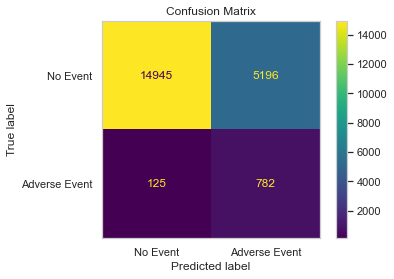

263
0.3979350694912722
0.3979350694912722
Positive Predictive Value 0.02 Negative Predictive Value 1.0  Specificty  0.7421830040283905 Sensitivity  0.6836734693877551


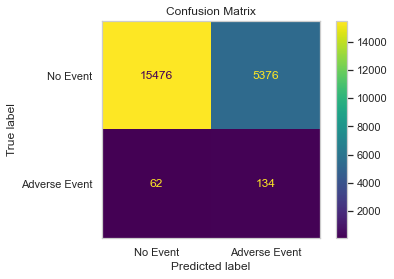

1023
0.45940651160283796
0.45940651160283796
Positive Predictive Value 0.1 Negative Predictive Value 0.99  Specificty  0.743868807249089 Sensitivity  0.7924528301886793


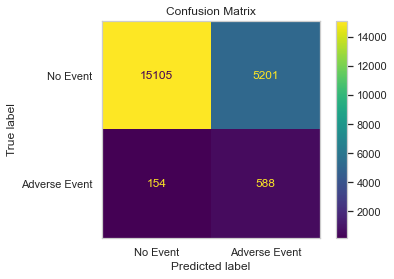

1916
0.45716718045293103
0.45716718045293103
Positive Predictive Value 0.2 Negative Predictive Value 0.98  Specificty  0.7337146980004123 Sensitivity  0.7858880778588808


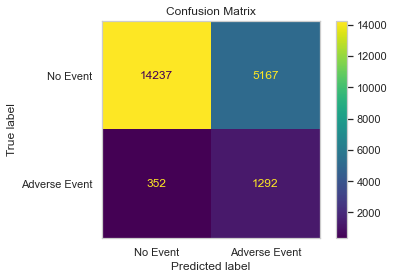

In [78]:
for file in lstFiles:
    df = pd.read_csv(file, names=columns)
    yhat = np.round(df['y_pred_proba'].map(sigmoid))
    testy, lr_probs = df['y'],df['y_pred_proba'].map(sigmoid)
    neg_count, pos_count = (format(df['y'].value_counts()[0],',d')),(format(df['y'].value_counts()[1],',d'))
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    # calculate scores
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    y_true,y_scores = df['y'],df['y_pred_proba'].map(sigmoid)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores,pos_label=1)
    total_count = format(len(df),',d')
    idx = np.argmax(tpr - fpr)
    youden_index = thresholds[idx]
    cm(y_true,y_scores, threshold=youden_index)